In [1]:
import numpy as np
import pandas as pd
import pymc3 as pm 
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# 第2章 PyMc3入門

#### コイントスを想定して、mcmc法を行う

In [2]:
##擬似データ生成
np.random.seed(123)
n_experiments = 4
theta_real = 0.35
data = stats.bernoulli.rvs(p=theta_real , size= n_experiments)

In [37]:
'''
尤度は二項分布から、事後分布はベータ分布を仮定して推定

書籍と違う点として、推論実行でのnjobsはデフォルトで2になっていること。
'''


##モデル定義
with pm.Model() as our_first_model:
    theta = pm.Beta('theta' , alpha=1,beta=1)
    y = pm.Bernoulli('y' , p=theta , observed = data)
    
    ##推論設定
    start = pm.find_MAP()
    #step = pm.Metropolis()
    #trace = pm.sample(1000, start = start , step = step, njobs=4)
    trace = pm.sample(1000, start = start , njobs=4)

/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -2.7726, ||grad|| = 1: 100%|██████████| 6/6 [00:00<00:00, 1758.50it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:01<00:00, 4017.37draws/s]
The acceptance probability does not match the target. It is 0.8809182654066945, but should be close to 0.8. Try to increase the number of tuning steps.


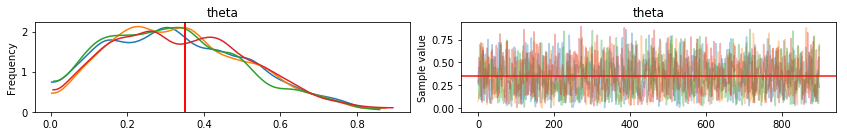

In [38]:
burnin = 100
chain = trace[burnin:]
pm.traceplot(chain , lines={'theta' : theta_real});

In [39]:
##事後分布の数値的評価: gelman rubin(理想は1.0だが、1.1未満であればよし)
pm.gelman_rubin(trace)

{'theta': 1.0012931310179614}

GridSpec(1, 2, width_ratios=[3, 1])

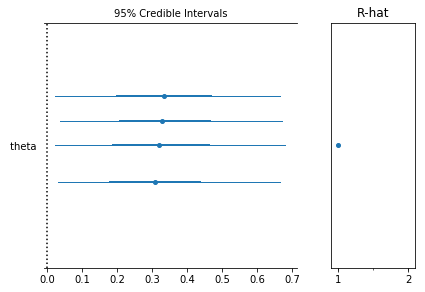

In [40]:
##各パラメータの分布の平均とその50%と95%信頼区間
pm.forestplot(trace , varnames={'theta'})

In [41]:
pm.summary(trace)

mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff      Rhat
theta  0.336398  0.178923  0.003864  0.029056  0.672914  1730.820252  1.001293

#### 自己相関のプロットや有効サイズの検証は実践的ベイズであることを念頭に置いておく

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2378ce80>,
      dtype=object)

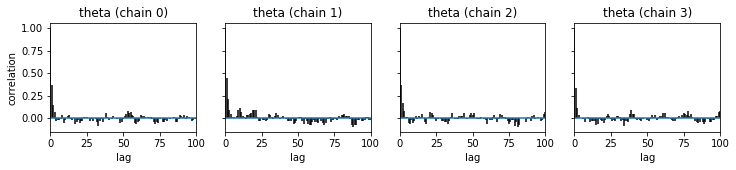

In [42]:
##自己相関をプロット
pm.autocorrplot(chain)

In [43]:
##有効サイズの計算
pm.effective_n(chain)['theta']

1622.5950082202876

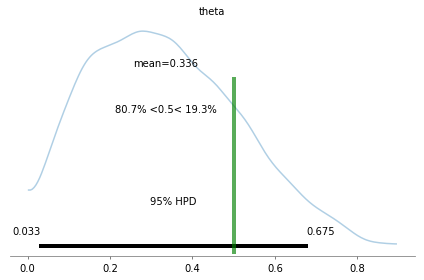

In [44]:
##事後分布と信頼区間のプロット
pm.plot_posterior(chain,kde_plot=True , ref_val=0.5)

# 第3章 複数パラメータの取り扱いと階層モデル

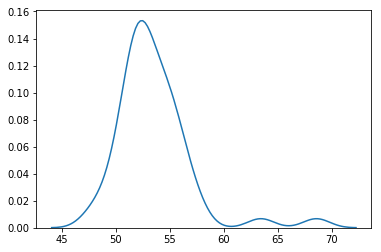

In [45]:
data = np.array([51.06, 55.12, 53.73, 50.24, 52.05, 56.40, 48.45, 52.34,
55.65, 51.49, 51.86, 63.43, 53.00, 56.09, 51.93, 52.31, 52.33, 57.48, 
57.44, 55.14, 53.93, 54.62, 56.09, 68.58, 51.36, 55.47, 50.73, 51.94, 
54.95, 50.39, 52.91, 51.50, 52.68, 47.72, 49.73, 51.82, 54.99, 52.84, 
53.19, 54.52, 51.46, 53.73, 51.61, 49.81, 52.42, 54.30, 53.84, 53.16])

import seaborn as sns

sns.kdeplot(data)

扱うデータは概ね正規分布だと考えられる。<br>
→尤度は正規分布、共役事前分布を用いて、事前分布は正規分布。パラメータの分布は平均は一様分布、標準偏差は半正規分布に従うとする。

/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -160.65, ||grad|| = 38.298: 100%|██████████| 10/10 [00:00<00:00, 2635.77it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [sigma, mu]
Sampling 3 chains: 100%|██████████| 4800/4800 [00:01<00:00, 3289.96draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c29fbfa20>,
      dtype=object)

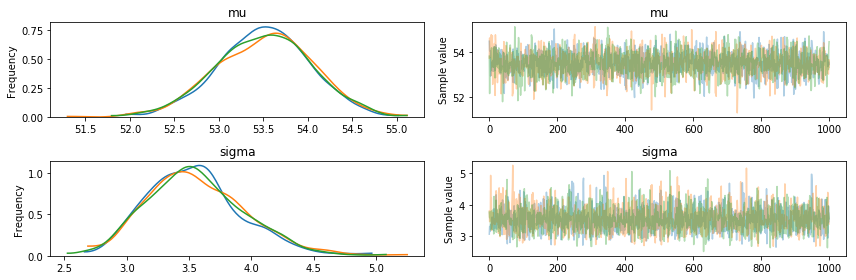

In [85]:
##ベイスモデル
with pm.Model() as model_g:
    mu = pm.Uniform('mu' , 40, 75)
    sigma = pm.HalfNormal('sigma' , sd = 10)
    y = pm.Normal('y' , mu=mu , sd=sigma , observed = data)
    
    ##推論設定
    start = pm.find_MAP()
    trace = pm.sample(1100 , start= start , njobs=3)
    
##周辺分布可視化
chain  =trace[100:]
pm.traceplot(chain)

In [86]:
df = pm.summary(chain)
print(df)

            mean        sd  mc_error    hpd_2.5   hpd_97.5        n_eff  \
mu     53.501086  0.528921  0.010794  52.468632  54.524371  2624.038260   
sigma   3.552138  0.388076  0.006605   2.885207   4.327119  2737.619937   

           Rhat  
mu     0.999549  
sigma  1.000073  


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 100/100 [00:00<00:00, 933.65it/s]
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


Text(0.5, 0, '$x$')

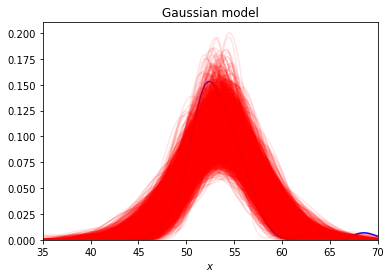

In [87]:
##事後分布の予測的サンプル
y_pred = pm.sample_ppc(chain , 100 , model_g , size=len(data))
sns.kdeplot(data , c= 'b')

for i in range(len(y_pred['y'])):
    for j in range(len(data)):
        sns.kdeplot(y_pred['y'][i][j] , c='r' , alpha = 0.1)
plt.xlim(35,70)
plt.title('Gaussian model')
plt.xlabel("$x$")

今回は、元データに外れ値(右端の凹凸)があるので厳密には、正規分布とは言えない。そこで、正規分布をt分布(自由度というパラメータを与えて、正規分布の派生的な分布を作る分布)として事前分布を設定。自由度は、事前分布として指数分布を仮定する。

/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -127.7, ||grad|| = 0.11119: 100%|██████████| 14/14 [00:00<00:00, 672.87it/s]  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [nu, sigma, mu]
Sampling 3 chains: 100%|██████████| 4800/4800 [00:02<00:00, 1853.32draws/s]
The acceptance probability does not match the target. It is 0.8934313005186986, but should be close to 0.8. Try to increase the number of tuning steps.


mean        sd  mc_error    hpd_2.5   hpd_97.5        n_eff  \
mu     53.008890  0.383203  0.008391  52.233668  53.714461  2180.327161   
sigma   2.181429  0.407997  0.010821   1.393805   2.946651  1253.893185   
nu      4.549679  4.633258  0.133835   1.077600  10.034566  1271.515982   

           Rhat  
mu     0.999842  
sigma  0.999764  
nu     1.000501

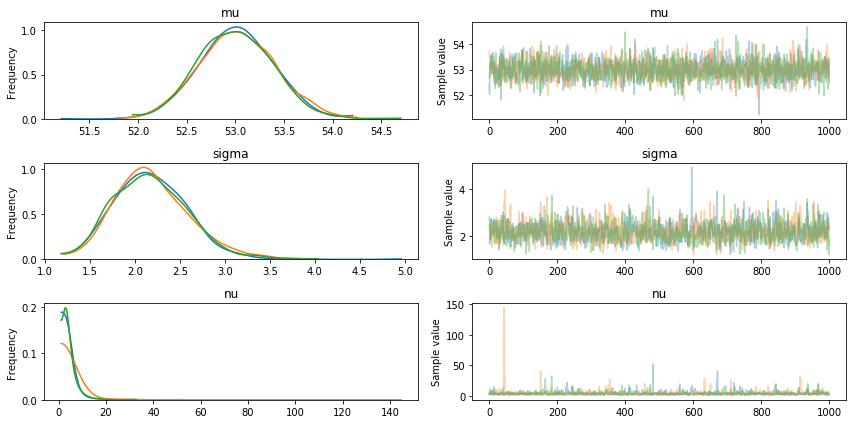

In [88]:
##モデル構築
with pm.Model() as model_t:
    mu = pm.Uniform('mu' , 40 , 70)
    sigma = pm.HalfNormal('sigma' , sd=10)
    nu = pm.Exponential('nu' , 1/30)
    y = pm.StudentT('y', mu=mu , sd=sigma , nu = nu , observed=data)
    
    ##推論設定
    start = pm.find_MAP()
    trace = pm.sample(1100 , start=start, njobs =3 )
    
##周辺分布の可視化
chain_t = trace[100:]
pm.traceplot(chain_t)
pm.summary(chain_t)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 100/100 [00:00<00:00, 830.81it/s]
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


Text(0.5, 0, '$x$')

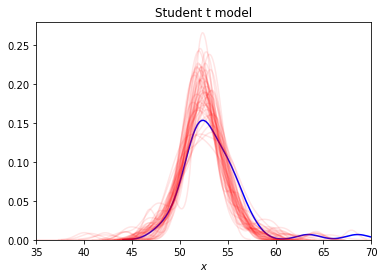

In [89]:
##事後分布予測サンプルの表示
y_pred = pm.sample_ppc(chain_t,  100, model_t , size=len(data))
sns.kdeplot(data , c='b' ,alpha=1.0)

for i in range(len(y_pred)):
    for j in range(len(data)):
        sns.kdeplot(y_pred['y'][i][j] , c='r' , alpha=0.1)
plt.xlim(35,70)
plt.title("Student t model")
plt.xlabel('$x$')

ここからは、グループ間の比較として新しいデータを追加する。今までは、スカラー(つまり、ある数値の分布の推定)だったが、ベクトル(ある変数に対しての同列の複数要素からの分布を推定する)

In [97]:
##データセットの用意
##tips = sns.load_dataset("tips")
##書いたときはgithubの障害で繋がらなかったので、ローカルにダウンロードしたデータを用いる
tips=pd.read_csv('/Users/shintaro/Downloads/tips.csv')
tips.head()

total_bill   tip     sex smoker  day    time  size
0       16.99  1.01  Female     No  Sun  Dinner     2
1       10.34  1.66    Male     No  Sun  Dinner     3
2       21.01  3.50    Male     No  Sun  Dinner     3
3       23.68  3.31    Male     No  Sun  Dinner     2
4       24.59  3.61  Female     No  Sun  Dinner     4

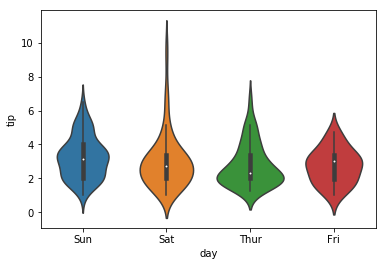

In [100]:
##データの可視化
sns.violinplot(x='day' , y='tip' , data=tips)

In [108]:
##各曜日を考慮して、tipの分布を調べる
y_tips = tips['tip'].values
idx = pd.Categorical(tips['day']).codes

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sds, means]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:13<00:00, 837.33draws/s]


mean        sd  mc_error   hpd_2.5  hpd_97.5         n_eff  \
means__0  2.732712  0.259329  0.002420  2.215666  3.239623   9649.493655   
means__1  2.993640  0.177303  0.001633  2.652148  3.343353  10963.305194   
means__2  3.255722  0.145732  0.001510  2.962611  3.533047  10496.272029   
means__3  2.771403  0.162935  0.001634  2.439594  3.081027  10546.715575   
sds__0    1.099353  0.201191  0.001808  0.748344  1.495030   8725.972029   
sds__1    1.655812  0.130082  0.001404  1.405905  1.914008   9666.936918   
sds__2    1.257233  0.106086  0.001025  1.062810  1.465948  10275.856423   
sds__3    1.268057  0.118595  0.001190  1.047936  1.505983  10913.502790   

              Rhat  
means__0  0.999905  
means__1  0.999925  
means__2  0.999911  
means__3  1.000041  
sds__0    0.999943  
sds__1    0.999992  
sds__2    1.000106  
sds__3    0.999905

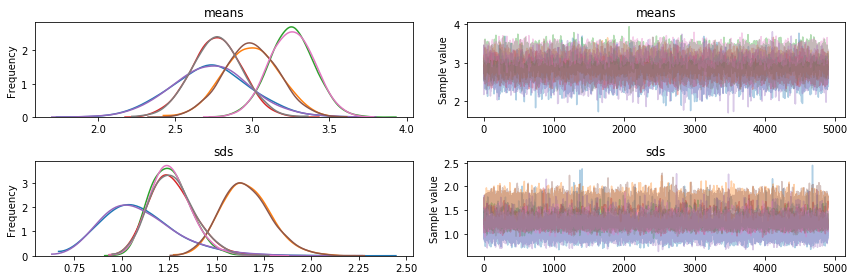

In [147]:
##モデル構築
##データがベクトルなので、shapeでデータのインデックスを指定して書く

with pm.Model() as model_groups:
    means = pm.Normal('means' ,mu=0 , sd =10 , shape=len(set(idx)))
    sds = pm.HalfNormal('sds' , sd = 10 , shape = len(set(idx)))
    y = pm.Normal('y' , mu=means[idx] , sd = sds[idx] , observed = y_tips)
    
    ##推論設定
    trace_gp = pm.sample(5000)
    
##周辺分布の可視化
chain_gp = trace_gp[100::]
pm.traceplot(chain_gp)
pm.summary(chain_gp)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
100%|██████████| 100/100 [00:00<00:00, 217.73it/s]
/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1725: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


Text(0.5, 0, '$x$')

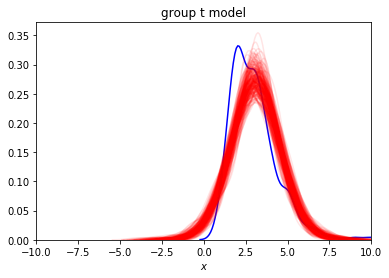

In [149]:
y_pred = pm.sample_ppc(chain_gp,  100, model_groups , size=len(y_tips))
sns.kdeplot(y_tips , c='b' ,alpha=1.0)

for i in range(len(y_pred)):
    for j in range(len(y_tips)):
        sns.kdeplot(y_pred['y'][i][j] , c='r' , alpha=0.1)
plt.xlim(-10,10)
plt.title("group t model")
plt.xlabel('$x$')

グループ(曜日間)でのチップに差があるかどうかの検定を行う

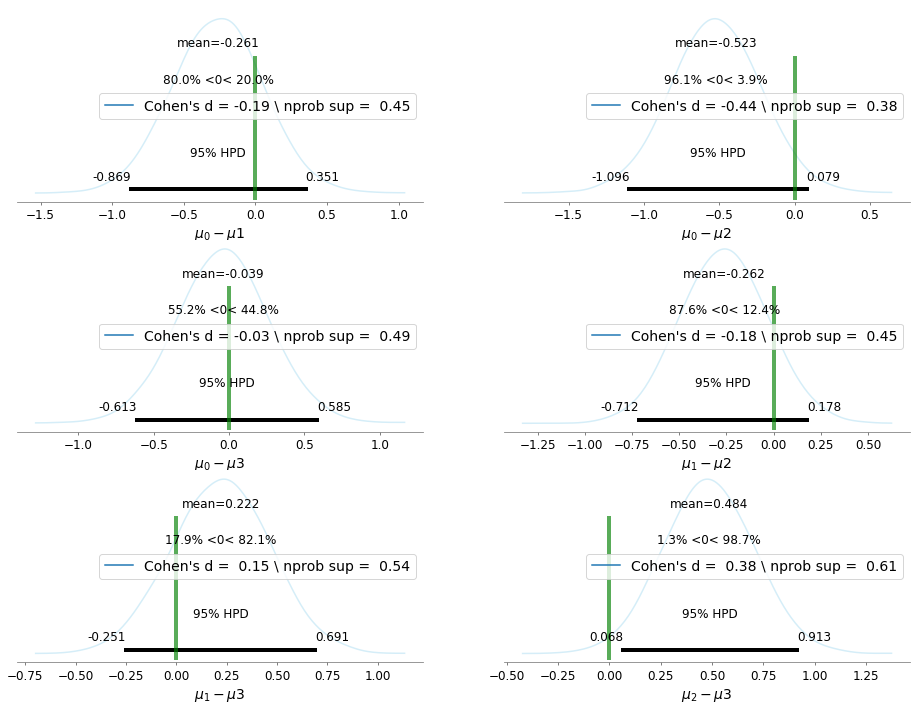

In [176]:
##優越率のために先に累積正規分布を定義
dist = stats.norm()
##グラフ表示のために先に定義
##前半の_は前半の内容を無視する意味になる( plt.fig()を無視する )
_ ,ax = plt.subplots(3,2 ,figsize=(16,12))

##差を比べたいから、自分以外のデータにアクセスできるようにforを書いている
comparison = [(i , j) for i in range(4) for j in range(i+1 , 4)]
##プロットの位置を明示的に書いておく
pos = [(k , l) for k in range(3) for l in (0,1)]

for (i , j) , (k , l) in zip(comparison , pos):
    means_diff = chain_gp['means'][:, i] - chain_gp['means'][: , j]
    ##コーエンのdの定義(ここで最後に平均を取るのは、全サンプリングの各々の差をとって、それらの平均をグループ間のコーエンのdとして与えるため)
    d_cohen = (means_diff / np.sqrt((chain_gp['sds'][: , i]**2 + chain_gp['sds'][: ,j]**2) / 2)).mean()
    ##優越率の定義
    ps = dist.cdf(d_cohen/(2**0.5))
               
    ##プロット内容の指定(ref_val=0はグループ間の平均に差がないことを表す)
    pm.plot_posterior(means_diff , ref_val=0, ax=ax[k , l], color = 'skyblue' , kde_plot=True)
    ##0とコーエン、優越率のプロット
    ax[k , l].plot(0 , label="Cohen's d = {: .2f} \ nprob sup = {: .2f}".format(d_cohen , ps) , alpha=1.0)
    ax[k , l].set_xlabel('$\mu_{}-\mu{}$'.format(i , j),fontsize=14)
    ax[k , l].legend(loc =0 ,fontsize=14)


↕︎平均の添え字の番号は以下を参照して、解釈する

In [186]:
pd.Categorical(tips['day'])

[Sun, Sun, Sun, Sun, Sun, ..., Sat, Sat, Sat, Sat, Thur]
Length: 244
Categories (4, object): [Fri, Sat, Sun, Thur]

In [187]:
idx

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3], dtype=int8)

# 第4章 線形回帰モデルによるデータの理解と予測

人口データを回帰直線直線に準ずるように発生させる

Text(0.5, 0, '$y$')

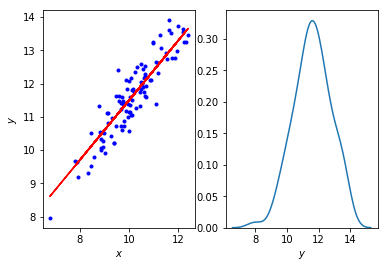

In [191]:
np.random.seed(314)
N=100
alfa_real=2.5
beta_real=0.9
eps_real=np.random.normal(0 , 0.5 , size=N)

x=np.random.normal(10 , 1 , N)
y_real = alfa_real + beta_real * x
y = y_real + eps_real

plt.figure()
plt.subplot(1,2,1)
plt.plot(x , y,  'b.')
plt.xlabel('$x$')
plt.ylabel('$y$')

plt.plot(x,  y_real , 'r')
plt.subplot(1 , 2 , 2)
sns.kdeplot(y)
plt.xlabel('$y$')

In [196]:
##モデル構築
with pm.Model() as model:
    alpha = pm.Normal('alpha' , mu=0 , sd = 10)
    beta = pm.Normal('beta' , mu=0 , sd = 1)
    epsilon = pm.HalfNormal('epsilon' , 5)
    
    mu = pm.Deterministic('mu' , alpha + beta *x)
    y_pred = pm.Normal('y_pred' , mu=mu , sd = epsilon , observed=y)
    
    ##推論設定
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(11000 , start=start , step =step , njobs=2)

/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -73.184, ||grad|| = 86.901: 100%|██████████| 38/38 [00:00<00:00, 2919.54it/s]  
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [epsilon]
>Metropolis: [beta]
>Metropolis: [alpha]
Sampling 2 chains: 100%|██████████| 23000/23000 [00:04<00:00, 5124.22draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c4ea89fd0>,
      dtype=object)

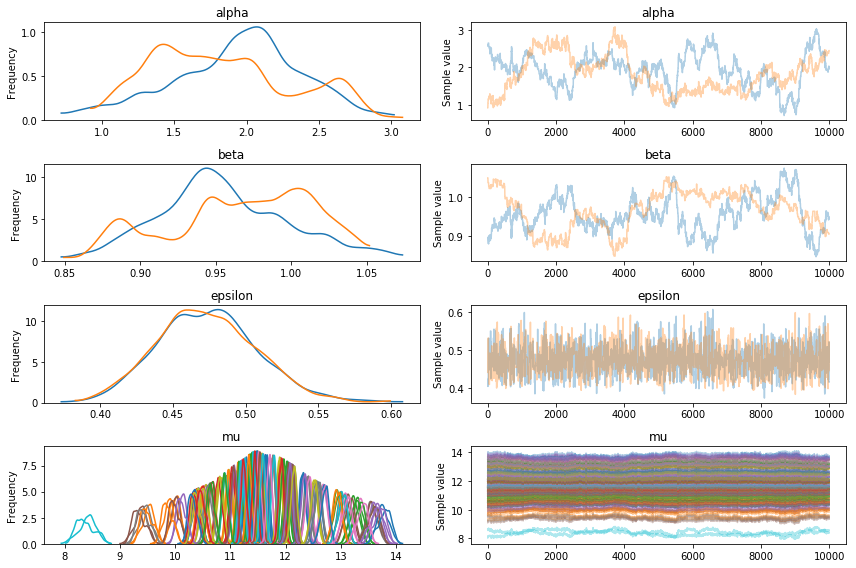

In [197]:
##事後分布のハイパーパラメータの可視化
trace_n = trace[1000:]
pm.traceplot(trace_n)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c551aa160>,
      dtype=object)

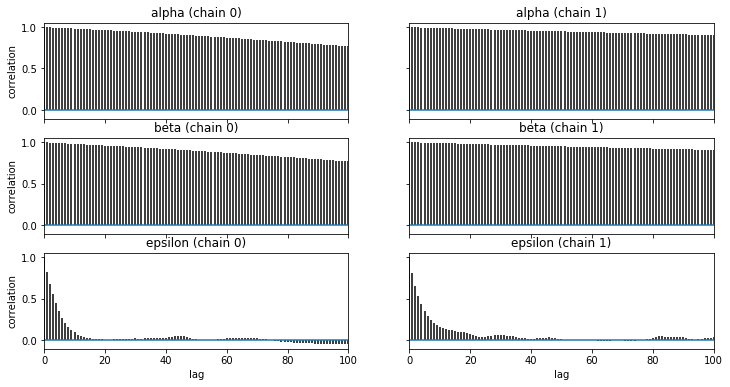

In [198]:
##自己相関の可視化
varnames = ['alpha' , 'beta' , 'epsilon']
pm.autocorrplot(trace_n,varnames)

サンプリングが上下しており、自己相関もかなり強いので、αとβのサンプリングはうまくいっていないことがわかる。<br>
解決法として、データの標準化やサンプリング方法の変更

ここでは実行しないが、線形的な関係にありそうな二つのデータの分布をベイズ的に求めて、さらにそのデータの相関を知りたい時のやり方がある<br>
① ピアソンの相関係数を直接計算<br>
② 最小二乗法的なやり方(テキスト参照)<br>
③ 多変量正規分布の共分散行列の推定をすること(共分散行列の中に相関係数ρが入るから、推定する→ρの推定と等しい)→多変量正規分布を推定する<br>

おそらく一般的なやり方は、③でρも事前分布として含めてしまうやり方。<br>
次の実行で、2変量の時の共分散行列の推定をする時の例を載せる(変量が増えれば、共分散行列の書き方も変わる(テキスト参照))

In [199]:
np.random.seed(314)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal( 0 , 0.5 , size=N)

x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x
y = y_real + eps_real

data = np.stack((x ,y)).T

In [202]:
data.shape

(100, 2)

In [ ]:
##モデル構築
with pm.Model() as pearson_model:
    ##2変量だからそれぞれの平均を与えて、shapeを2にしている
    mu = pm.Normal('mu' , mu=data.mean(0) , sd=10 , shape=2 )
    ##共分散行列の定義をするため、σは一つ一つ定義する
    sigma1 = pm.HalfNormal('sigma1' , 10)
    sigma2 = pm.HalfNormal('sigma2' , 10)
    rho = pm.Uniform('rho' , -1, 1)
    
    ##共分散行列の定義
    cov = pm.math.stack(( [sigma1**2 , rho*sigma1*sigma2 ] , [rho*sigma1*sigma2 ,  sigma2**2 ]))
    
    y_pred = pm.MvNormal('y_pred' , mu = mu , cov = cov , observed=data)
    
    ##推論設定
    start = pm.find_MAP()
    step = pm.NUTS(scaling = start)
    
    trace_mv = pm.sample(1000 , start=start , step=step , njobs=3)
    
##周辺分布の可視化
pm.traceplot(trace_mv)


次にあるデータが目的変数に対して線形的で、なおかつそのあるデータをいくつかのグループ分けできる場合を考える。そんな時、あるデータはデータ全体だけでなく、データのグループごとに同時にモデリングできる。各グループは、他のグループの推定にも役立つ。そこで、複数グループ化でき、あるグループだけ少ないような場合でも線形関係に置ける定数項に事前分布をおいてあげる(階層化する)ことで質の良い事後分布が得られる。

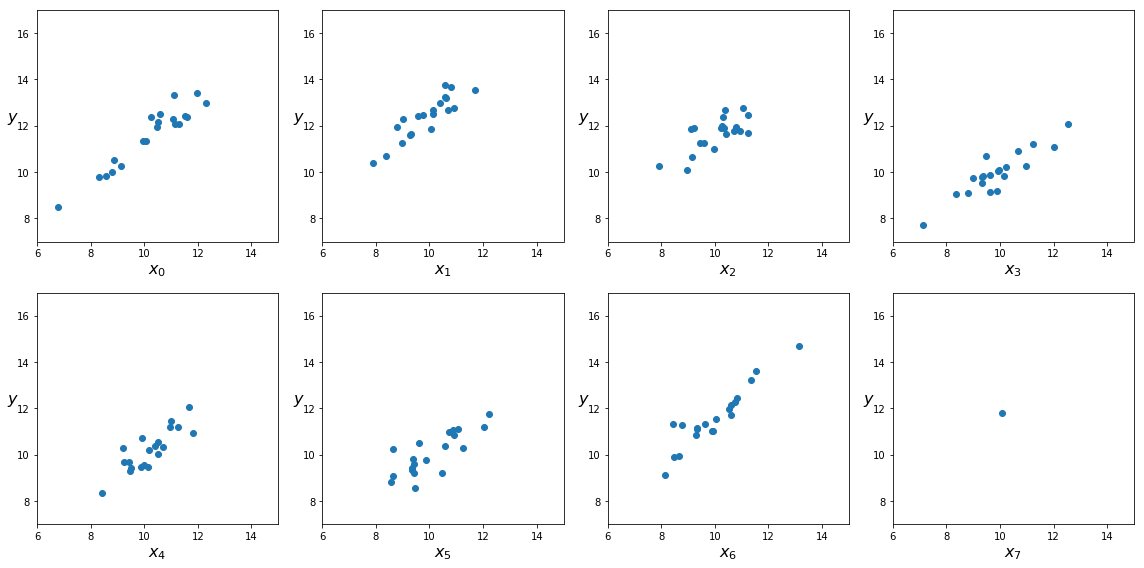

In [2]:
##データの作成と表示
N = 20
M = 8
idx = np.repeat(range(M-1), N)
idx = np.append(idx, 7)
np.random.seed(314)

alpha_real = np.random.normal(2.5, 0.5, size=M)
beta_real = np.random.beta(6, 1, size=M)
eps_real = np.random.normal(0, 0.5, size=len(idx))

y_m = np.zeros(len(idx))
x_m = np.random.normal(10, 1, len(idx))
y_m = alpha_real[idx] + beta_real[idx] * x_m  + eps_real

plt.figure(figsize=(16,8))
j, k = 0, N
for i in range(M):
    plt.subplot(2,4,i+1)
    plt.scatter(x_m[j:k], y_m[j:k])
    plt.xlabel('$x_{}$'.format(i), fontsize=16)
    plt.ylabel('$y$', fontsize=16, rotation=0)
    plt.xlim(6, 15)
    plt.ylim(7, 17)
    j += N
    k += N
plt.tight_layout()

/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -150.1, ||grad|| = 0.063835: 100%|██████████| 75/75 [00:00<00:00, 1516.50it/s]  
Sequential sampling (2 chains in 1 job)
NUTS: [nu, epsilon, beta, alpha_tmp]
100%|██████████| 2500/2500 [00:03<00:00, 703.77it/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c43f56fd0>,
      dtype=object)

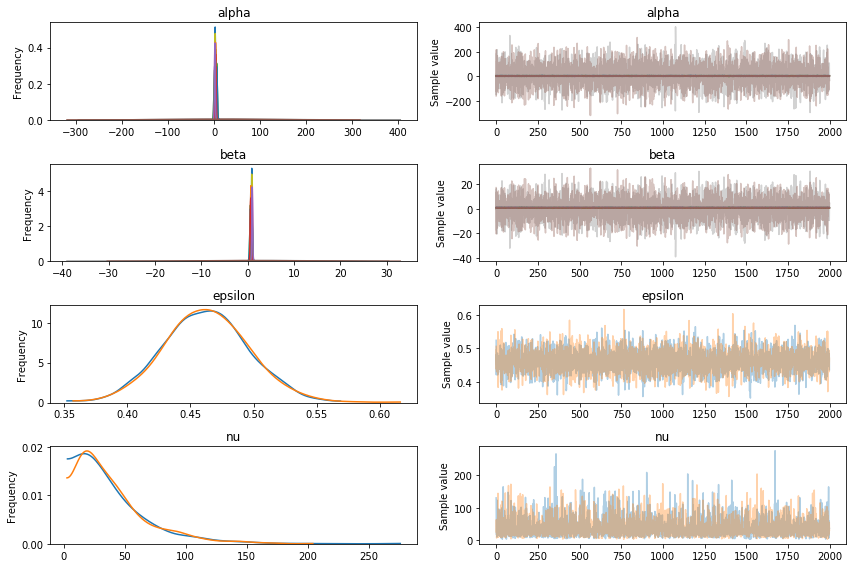

In [211]:
##データの中心化
x_centered = x_m - x_m.mean()

##モデル構築
with pm.Model() as unpooled_model:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=10, shape=M)
    beta = pm.Normal('beta', mu=0, sd=10, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)
    y_pred = pm.StudentT('y_pred', mu= alpha_tmp[idx] + beta[idx] * x_centered, sd=epsilon, nu=nu, observed=y_m)
    ##データを中心化しているので、元のデータの尺度でαを見るために再計算する
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace_up = pm.sample(2000, step=step, start=start, njobs=1)

varnames=['alpha', 'beta', 'epsilon', 'nu']
pm.traceplot(trace_up, varnames)

α、β、νはサンプリングに失敗していることが周辺分布とトレースからわかる<br>
これはグループの中に一つしかサンプルがないものがあるから回帰係数の推定ができない。<br>
この解決法として、他のグループからの情報を共有するといった考え方で、階層化してしまうやり方が良い。

In [6]:
##データの中心化
x_centered = x_m - x_m.mean()

##回帰係数のパラメータも階層化して表現してしまう。

##モデル構築
with pm.Model() as hierarchical_model:
    ##尤度関数のパラメータをさらに階層化
    alpha_tmp_mu = pm.Normal('alpha_tmp_mu', mu=0, sd=10)
    alpha_tmp_sd = pm.HalfNormal('alpha_tmp_sd', 10)
    beta_mu = pm.Normal('beta_mu', mu=0, sd=10)
    beta_sd = pm.HalfNormal('beta_sd', sd=10)

    ##事前分布の設定(グループ化しているからshapeで指定する必要がある)
    alpha_tmp = pm.Normal('alpha_tmp', mu=alpha_tmp_mu, sd=alpha_tmp_sd, shape=M)
    beta = pm.Normal('beta', mu=beta_mu, sd=beta_sd, shape=M)
    epsilon = pm.HalfCauchy('epsilon', 5)
    nu = pm.Exponential('nu', 1/30)

    ##尤度の設定
    y_pred = pm.StudentT('y_pred', mu=alpha_tmp[idx] + beta[idx] * x_centered, sd=epsilon, nu=nu, observed=y_m)

    ##データを中心化しているので、元の尺度に戻す
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_m.mean()) 
    alpha_mu = pm.Deterministic('alpha_mu', alpha_tmp_mu - beta_mu * x_m.mean())
    alpha_sd = pm.Deterministic('alpha_sd', alpha_tmp_sd - beta_mu * x_m.mean())
  
    trace_hm = pm.sample(1000, njobs=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [nu, epsilon, beta, alpha_tmp, beta_sd, beta_mu, alpha_tmp_sd, alpha_tmp_mu]
100%|██████████| 1500/1500 [00:04<00:00, 316.29it/s]
There were 39 divergences after tuning. Increase `target_accept` or reparameterize.
There were 110 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1859f898>,
      dtype=object)

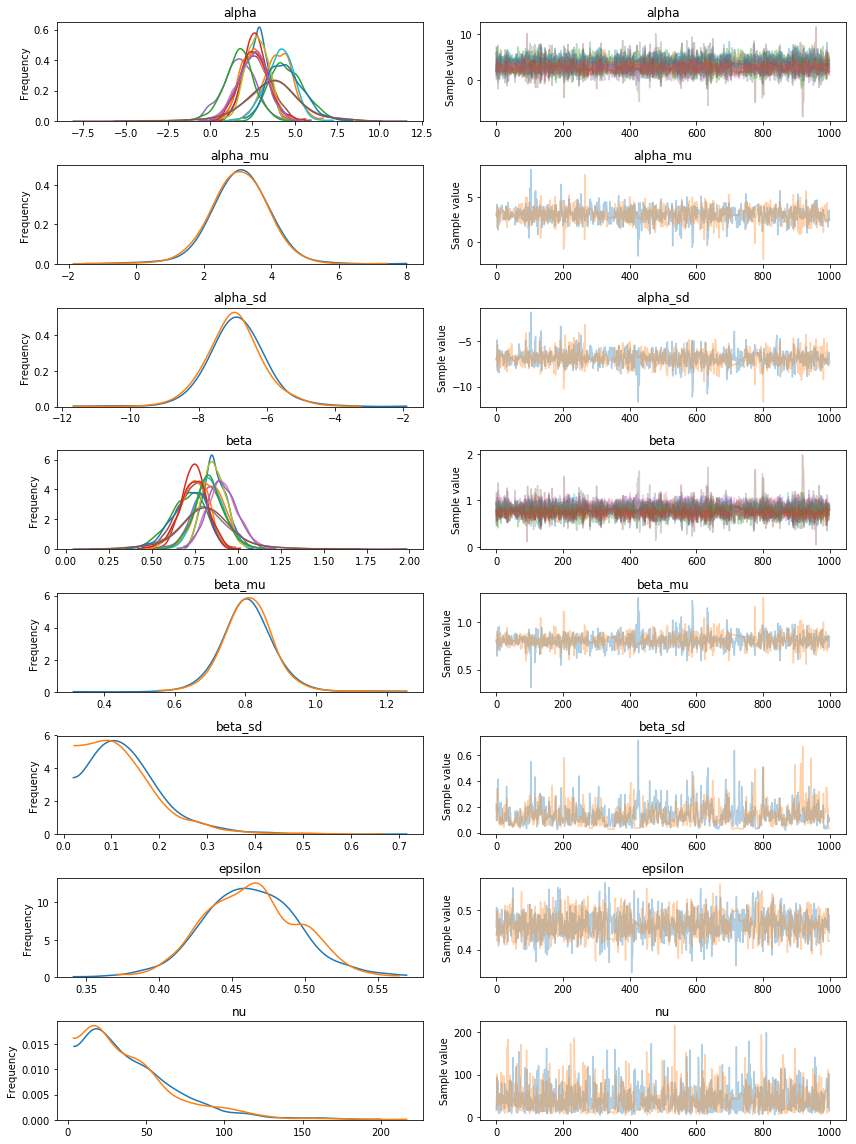

In [7]:
##周辺分布の可視化

varnames = ['alpha' , 'alpha_mu' , 'alpha_sd' , 'beta' , 'beta_mu' , 'beta_sd' , 'epsilon' , 'nu']
pm.traceplot(trace_hm , varnames)

線形重回帰によるモデリング

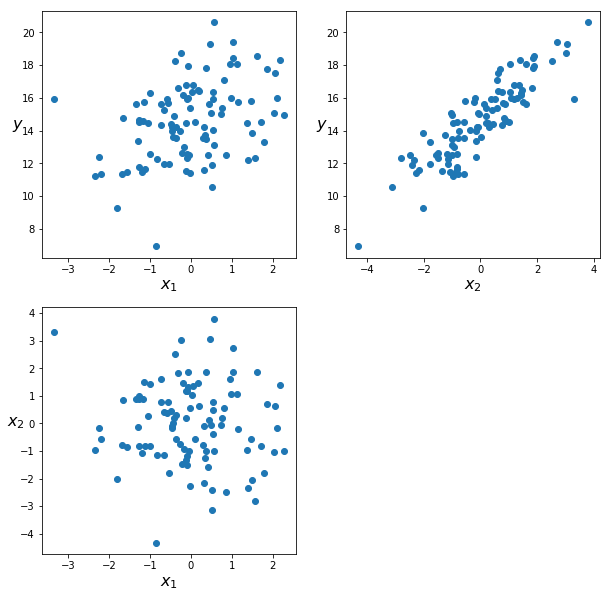

In [2]:
##データの用意
np.random.seed(314)
N=100
alpha_real = 2.5
beta_real = [0.9 , 1.5]
eps_real = np.random.normal(0 , 0.5 , size=N)

X = np.array([np.random.normal(i , j , N) for i,j in zip([10 , 2] , [1 , 1.5])])
X_mean = X.mean(axis = 1 , keepdims=True)
X_centered = X - X_mean
##説明変数と目的変数の関係を見る
y = alpha_real + np.dot(beta_real , X) + eps_real

##変数間の関係を見るための関数を定義
def scatter_plot(x , y):
    plt.figure(figsize = (10 , 10))
    ##目的変数と説明変数とのプロット
    for idx , x_i in enumerate(x):
        ##enumerateをとindexごとの要素全てを取り出すことができる
        plt.subplot(2 ,2 , idx+1)
        plt.scatter(x_i , y)
        plt.xlabel('$x_{}$'.format(idx + 1) , fontsize=16)
        plt.ylabel('$y$' , rotation = 0 , fontsize=16)
    
    
    ##従属変数同士のプロット
    plt.subplot(2 , 2 , idx+2)
    plt.scatter(x[0] , x[1])
    plt.xlabel('$x_{}$'.format(idx) , fontsize=16)
    plt.ylabel('$x_{}$'.format(idx+1) , rotation = 0 , fontsize=16)

    
scatter_plot(X_centered  ,y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [epsilon, beta, alpha_tmp]
Sampling 3 chains: 100%|██████████| 16500/16500 [00:08<00:00, 1875.33draws/s]
The acceptance probability does not match the target. It is 0.884337535358, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.882915341751, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25ca4198>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c25ab9b38>]], dtype=object)

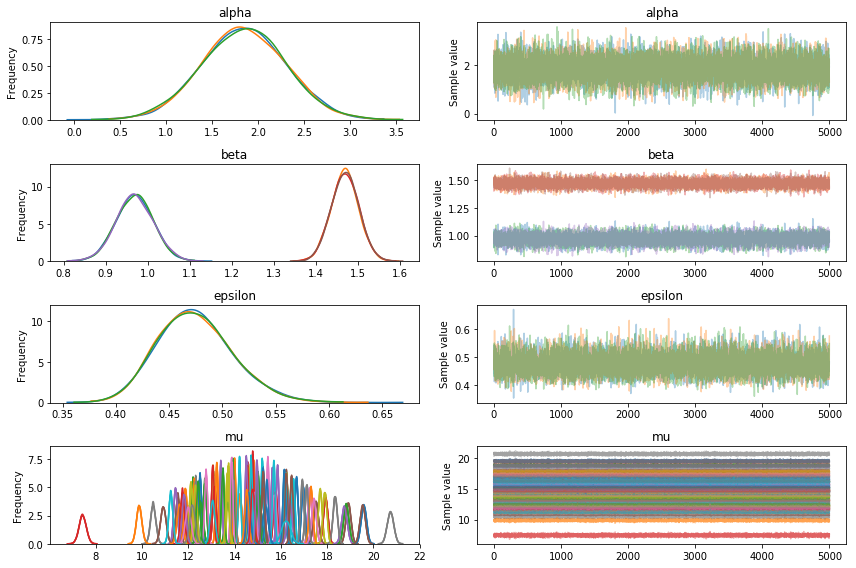

In [6]:
##モデル定義
with pm.Model() as model_mlr:
    ##各パラメータの階層化
    alpha_tmp = pm.Normal('alpha_tmp' , mu=0 , sd=10)
    beta = pm.Normal('beta' , mu = 0 , sd = 1 , shape=2)
    epsilon = pm.HalfCauchy('epsilon' , 5)
    ##パラメータの事前分布の設定
    ##muの書き方はどちらでも良い。というのも、変数同士の加算や掛け算などの計算がされたものはDeterministic変数として扱われる。
    ##あえて、Deterministicとして宣言するのは、周辺分布のサンプリングを見たい時に設定する。
    mu = alpha_tmp+ pm.math.dot(beta , X_centered)
    #mu = pm.Deterministic('mu' , alpha_tmp +pm.math.dot(beta , X_centered) )
    ##元のデータ尺度への変換
    alpha = pm.Deterministic('alpha' , alpha_tmp - pm.math.dot(beta , X_mean))
    ##尤度の設定
    y_pred = pm.Normal('y_pred' , mu=mu , sd = epsilon , observed = y)
    
    ##推論設定
    trace_mlr = pm.sample(5000 , njobs=3)
    
    
##周辺分布の可視化
varnames = ['alpha' , 'beta' , 'epsilon' ,'mu']
pm.traceplot(trace_mlr , varnames)

In [46]:
pm.summary(trace_mlr , varnames)

mean        sd  mc_error   hpd_2.5  hpd_97.5         n_eff  \
alpha__0  1.856227  0.454468  0.003294  0.965576  2.735685  18864.335347   
beta__0   0.968215  0.043687  0.000306  0.882566  1.054175  19872.179888   
beta__1   1.469946  0.032473  0.000220  1.407684  1.534527  16083.316843   
epsilon   0.474273  0.034956  0.000251  0.406124  0.541863  14437.248707   

              Rhat  
alpha__0  1.000091  
beta__0   1.000086  
beta__1   0.999905  
epsilon   0.999933

次に交絡変数を仮定したデータで線形回帰を行う

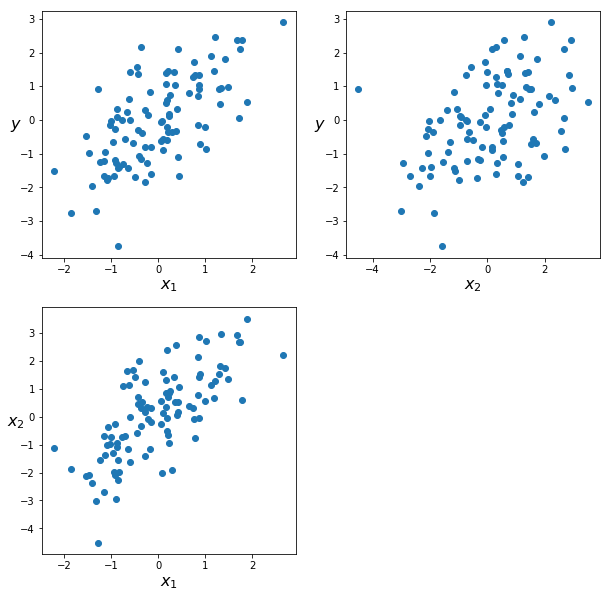

In [21]:
##データの作成
np.random.seed(314)
N =100
x_1 = np.random.normal(size=N)
x_2 = x_1+ np.random.normal(size=N , scale=1)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1 , x_2))

scatter_plot(X , y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, beta, alpha]
100%|██████████| 5500/5500 [00:04<00:00, 1193.67it/s]


mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
alpha    0.002052  0.099194  0.000967 -0.197634  0.189692  9526.544524   
beta__0  0.956459  0.153994  0.001735  0.655216  1.253977  7397.289829   
beta__1 -0.052764  0.093545  0.001140 -0.235981  0.129088  7459.537905   
epsilon  1.005854  0.073009  0.000837  0.866260  1.146749  8387.490579   

             Rhat  
alpha    0.999938  
beta__0  0.999925  
beta__1  0.999900  
epsilon  0.999967

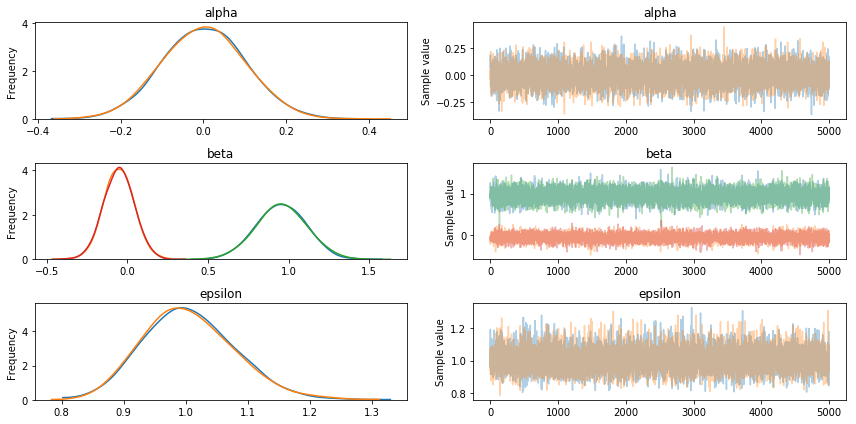

In [22]:
##モデル構築
with pm.Model() as model_red:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)
  
    mu = alpha + pm.math.dot(beta, X)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
  
    trace_red = pm.sample(5000, njobs=1)

pm.traceplot(trace_red)

pm.summary(trace_red)

↑beta_1がほどんど0になっている。これは、x_2がモデルに貢献していないことを表す。

ここからは多重共線性の理解に務める

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, beta, alpha]
100%|██████████| 5500/5500 [01:24<00:00, 64.71it/s]


Text(0, 0.5, '$\\beta_2$')

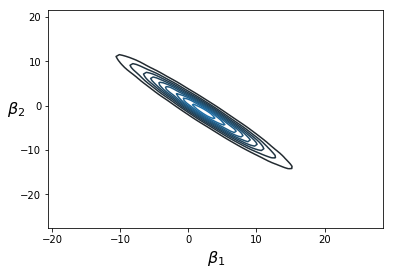

In [26]:
##説明変数の相関をかなり高いものに設定する
x_2 = x_1+np.random.normal(size=N , scale=0.01)
y = x_1 + np.random.normal(size=N)
X = np.vstack((x_1 , x_2))

##モデル構築
with pm.Model() as model_red:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)
  
    mu = alpha + pm.math.dot(beta, X)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
  
    trace_red = pm.sample(5000, njobs=1)
    
##二次元のkdeplotを描く
sns.kdeplot(trace_red['beta'][:,0], trace_red['beta'][:,1])
plt.xlabel(r'$\beta_1$', fontsize=16)
plt.ylabel(r'$\beta_2$', fontsize=16, rotation=0)

GridSpec(1, 2, width_ratios=[3, 1])

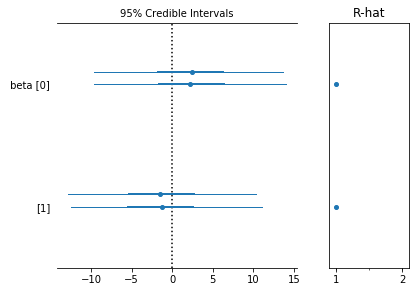

In [27]:
##βのHPDのプロット
pm.forestplot(trace_red, varnames=['beta'])

多重共線性が変数間にあると、HPDの幅も広くなるし、片方の値が上がるともう片方の値は小さくなる<br>
独立変数間に強い相関がある時の解決法<br>
①片方の変数を削除する。削除するのはモデルの説明がしにくい、解釈がしにくいものを選ぶと効率的。<br>
②変数間を平均化して新しい変数を作る。PCAで変数削除をするのもあり。(PCAを使うと変数の解釈は難しくなることは注意)<br>
③強い事前分布を使って、係数の取りうるもっともらしい値に制約を置く。(第6章で詳しく説明)

**変数のマスキング効果(説明変数が反対の効果を持っており、そのどちらかを削除するとどちらも組み込んだモデルよりもそれぞれの係数を過小に評価してしまうことを表す)**<br>
複数の説明変数があり、片方が目的変数に対して強い相関があり、もう片方が負の相関がある時にさっきと同じようなことが起こる。

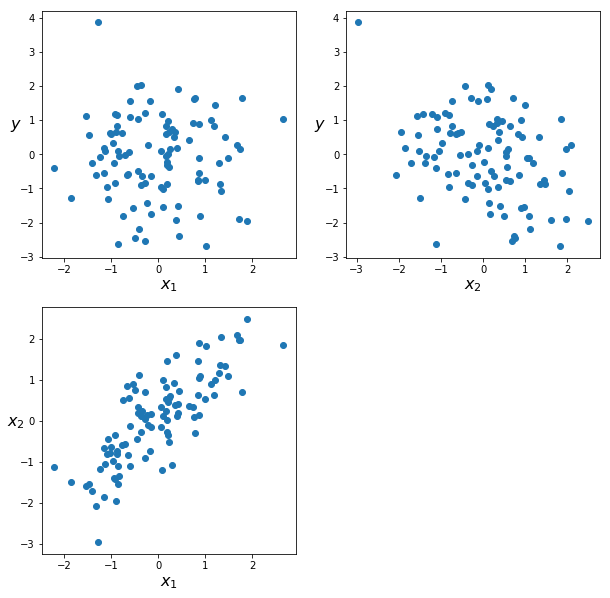

In [29]:
np.random.seed(314)
N=100
r =0.8

x_1 = np.random.normal(size=N)
x_2 = np.random.normal(loc=x_1 * r, scale=(1 - r ** 2) ** 0.5)
y = np.random.normal(loc=x_1 - x_2)
X = np.vstack((x_1, x_2))

scatter_plot(X,y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, beta, alpha]
100%|██████████| 5500/5500 [00:04<00:00, 1145.80it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1cd5b748>,
      dtype=object)

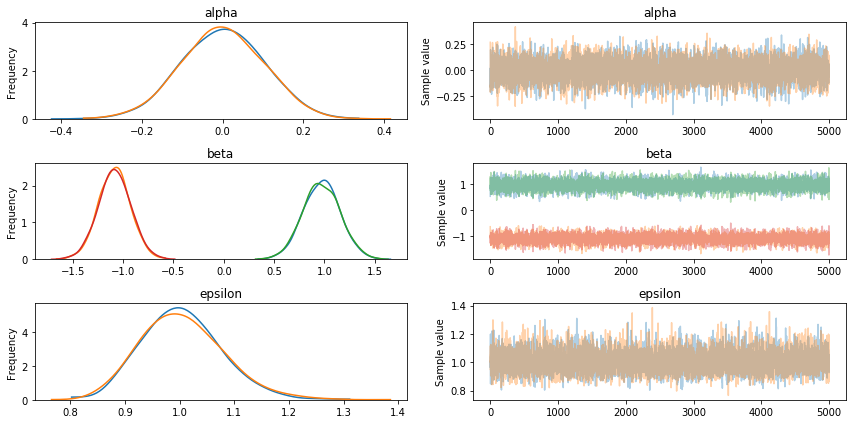

In [30]:
with pm.Model() as model_ma:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    epsilon = pm.HalfCauchy('epsilon', 5)

    mu = alpha + pm.math.dot(beta, X)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)

    trace_ma = pm.sample(5000, njobs=1)

pm.traceplot(trace_ma)

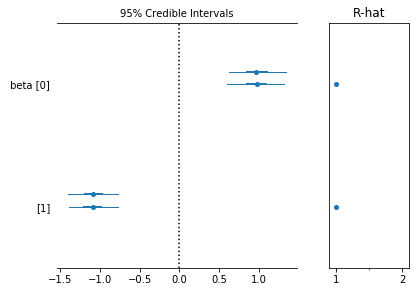

In [33]:
pm.forestplot(trace_ma, varnames=['beta']);

相互作用の追加(変数を独立して扱うのではなく、変数を加算的なものに加えて変数の掛け算したものを追加する)をするのもモデリングでは有効な手段

# 第5章 ロジスティック回帰による結果変数の分類

In [42]:
iris = pd.read_csv('/Users/shintaro/Downloads/BAP/iris.csv')
iris.head()

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa

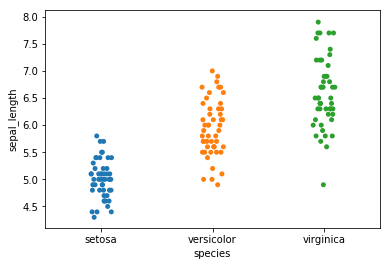

In [45]:
sns.stripplot(x = 'species' , y = 'sepal_length' , data=iris)

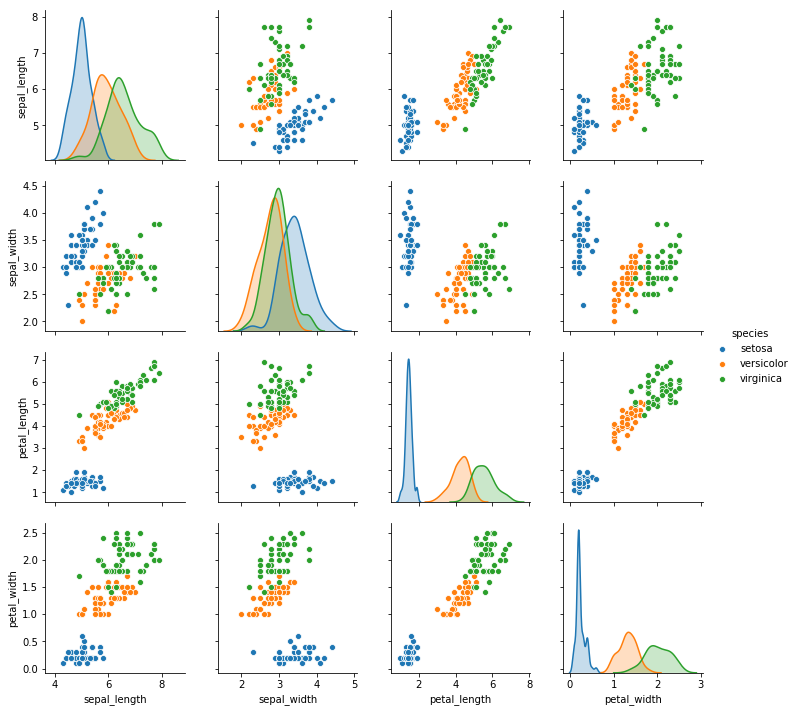

In [46]:
sns.pairplot(iris , hue = 'species' , diag_kind='kde')

多重ロジスティック回帰　

In [71]:
##データの用意
df = iris.query("species == ('setosa' , 'versicolor')")
y_1 = pd.Categorical(df['species']).codes
x_n = ['sepal_length' , 'sepal_width']
x_1 = df[x_n].values

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha]
Sampling 2 chains: 100%|██████████| 11000/11000 [00:23<00:00, 472.93draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1f303a58>,
      dtype=object)

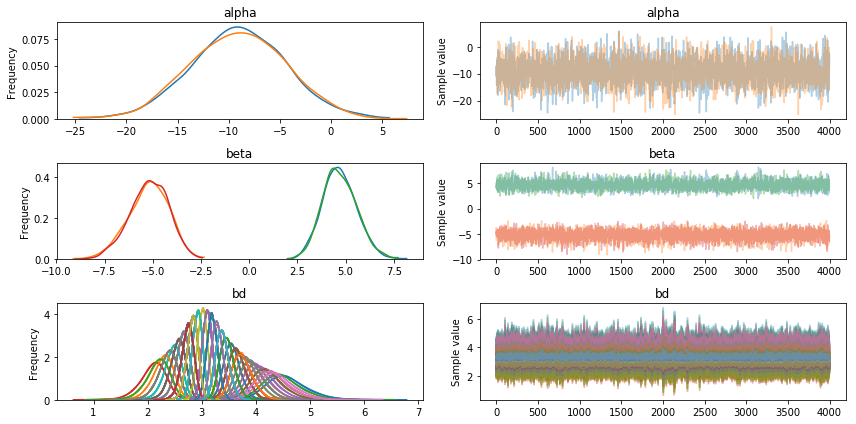

In [72]:
##モデル定義
##pymc3の多次元パラメータは一次元で与えられるため、線形回帰の行列の内積を考える時は、この場合は先にデータの方を与える
with pm.Model() as model_1:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=2, shape=len(x_n))
    mu = alpha + pm.math.dot(x_1, beta)
    theta = 1 / (1 + pm.math.exp(-mu))
    bd = pm.Deterministic('bd' , -alpha/beta[1] - beta[0]/ beta[1]*x_1[: , 0] )
    yl = pm.Bernoulli('yl' , p=theta , observed  =y_1)
    trace_1 = pm.sample(5000)

##周辺分布の可視化
chain_1  =trace_1[1000:]
varnames = ['alpha' , 'beta' , 'bd']
pm.traceplot(chain_1 , varnames)

Text(0, 0.5, 'sepal_width')

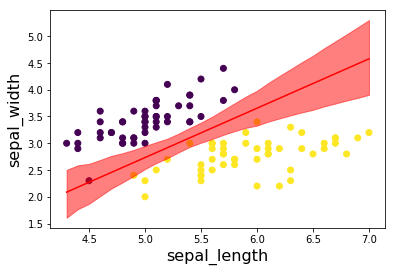

In [73]:
y_0 = pd.Categorical(df['species']).codes
##x_1の0列目のデータの大きい順に境界線の平均をとる
idx = np.argsort(x_1[:,0])
ld = chain_1['bd'].mean(0)[idx]

plt.scatter(x_1[:,0], x_1[:,1], c=y_0, cmap='viridis')
plt.plot(x_1[:,0][idx], ld, color='r');

##境界線の信頼区間95%をプロット
ld_hpd = pm.hpd(chain_1['bd'])[idx]
plt.fill_between(x_1[:,0][idx], ld_hpd[:,0], ld_hpd[:,1], color='r', alpha=0.5);

plt.xlabel(x_n[0], fontsize=16)
plt.ylabel(x_n[1], fontsize=16)

irisデータはクラス間のサンプルバランスが綺麗だが、通常は不均衡なデータとなる。<br>
その場合は、データ数を増やすか、より多くの事前分布を与えること。

ここまでは、ニクラス分類を考えてきたが、ここからは2以上のクラスで分類するために一般化化線形モデルを見ていく。<br>
各クラスを全ての説明変数を使って予測する

In [80]:
y_s = pd.Categorical(iris['species']).codes
x_n = iris.columns[ : -1]
x_s = iris[x_n].values
##説明変数ごとに標準化
x_s = (x_s - x_s.mean(axis=0))/x_s.std(axis=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta, alpha]
Sampling 3 chains: 100%|██████████| 7500/7500 [00:17<00:00, 420.21draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1f69dbe0>,
      dtype=object)

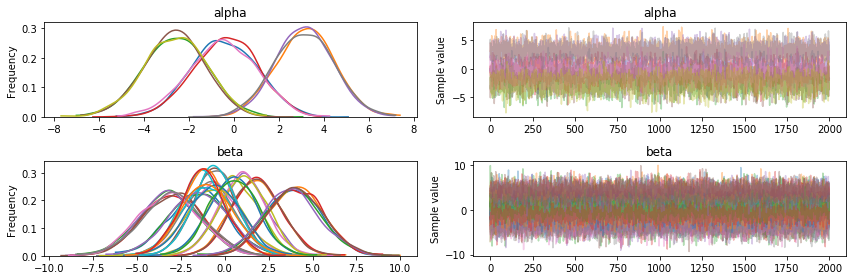

In [83]:
import theano.tensor as tt

##モデル構築
with pm.Model() as model_s:
    ##予測するクラスが3つだから、shapeは3
    alpha = pm.Normal('alpha' , mu=0 , sd=2  ,shape=3)
    beta = pm.Normal('beta' , mu=0 , sd=2 , shape=(4,3))
    mu = alpha + pm.math.dot(x_s , beta)
    theta = tt.nnet.softmax(mu)
    yl = pm.Categorical('yl' , p=theta , observed=y_s)
    
    ##推論
    trace_s  =pm.sample(2000 , njobs = 3)
    
##周辺分布の表示
pm.traceplot(trace_s)

In [87]:
##モデルの予測制度を計算する
data_pred = trace_s['alpha'].mean(axis=0) + np.dot(x_s , trace_s['beta'].mean(axis=0))
y_pred = []

for point in data_pred:
    y_pred.append(np.exp(point)/np.sum(np.exp(point) , axis=0))
np.sum(y_s == np.argmax(y_pred , axis=1)) / len(y_s)

0.9733333333333334

事後分布の幅が広くなっている。これだと未知データセットに対する予測は弱くなる(このノートブックではやっていないが、線形回帰やロジスティックで説明変数間に相関を持たせた場合の周辺分布と同じような幅の広い周辺分布が得られてしまうため)<br>
解決法としては、一つのパラメータを固定させてしまうこと

# 第6章 モデル比較

大きく分けて、交差確認と情報量基準がある。<br>
特に情報量基準をベイズで使う時は、DIC , WAIC、LOOCVを使うことが多い。<br>
そして、pymc3では、pm.dic(trace=hoge , model=hogehoge)で取得できる。同様に、pm.waic、pm.looを使うことで取得できる。

**注意点<br>
WAIC,LOOCV実行時に警告が出ることがある。これは、経験的な値で設定されており、この値を超える(警告が出る)時は、サンプリングのトレースがうまくいっているか、バーンインが適切の用いられているかを検証すべし。その辺を改善しても、警告が出る時は正規分布ではなく、スチューデントのt分布を使うべき。それでもダメなら、k分割検証などの方法でモデル比較を行なった方が安心。**

一方で、全てのモデルを活かすという方針で、モデルの平均化というのもあり。

最後に情報量基準の例を載せて終わりにする

Text(0, 0.5, '$y$')

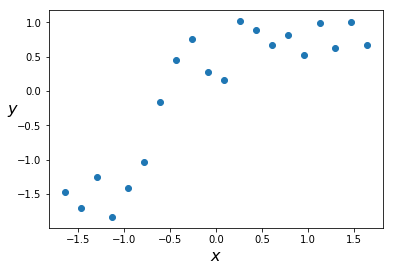

In [95]:
##擬似データの作成
real_alpha = 4.25
real_beta = [8.7, -1.2]
data_size = 20
noise = np.random.normal(0, 2, size=data_size)
x_1 = np.linspace(0, 5, data_size)
y_1 = real_alpha + real_beta[0] * x_1 + real_beta[1] * x_1**2 + noise

order = 2
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True))/x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean())/y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, beta, alpha]
100%|██████████| 2600/2600 [00:01<00:00, 1576.80it/s]


mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
alpha   -0.003001  0.129026  0.002007 -0.258846  0.247277  3901.529087   
beta     0.843950  0.128022  0.001988  0.601253  1.111042  3931.306188   
epsilon  0.576504  0.104521  0.001862  0.401135  0.786360  3627.095443   

             Rhat  
alpha    0.999972  
beta     1.000209  
epsilon  0.999776

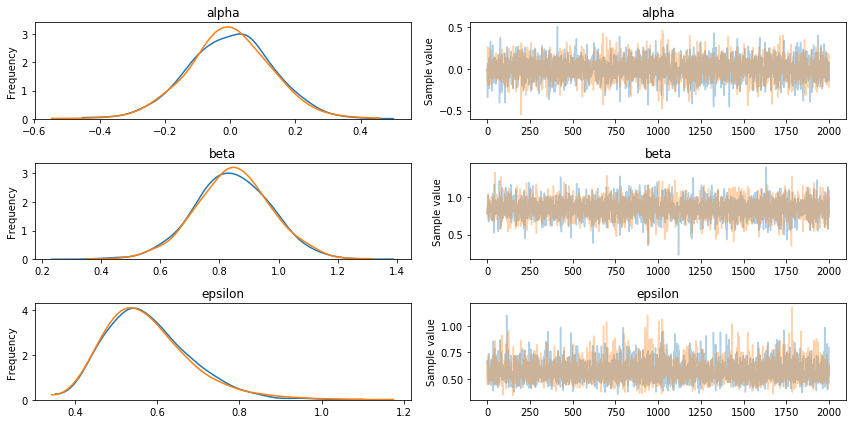

In [96]:
##1次の線形回帰モデル
with pm.Model() as model_l:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    mu = alpha + beta * x_1s[0]
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_1s)
  
    trace_l = pm.sample(2100, njobs=1)

chain_l = trace_l[100:]
pm.traceplot(chain_l);

pm.summary(chain_l)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [epsilon, beta, alpha]
100%|██████████| 2600/2600 [00:04<00:00, 556.36it/s]
The acceptance probability does not match the target. It is 0.8818686236166582, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8878073395103835, but should be close to 0.8. Try to increase the number of tuning steps.


mean        sd  mc_error   hpd_2.5  hpd_97.5        n_eff  \
alpha   -0.000706  0.104577  0.002028 -0.204749  0.213360  2297.687958   
beta__0  1.726983  0.375993  0.009186  0.961834  2.427559  1689.511140   
beta__1 -0.916158  0.376591  0.009097 -1.623509 -0.147979  1680.623817   
epsilon  0.454772  0.091882  0.002195  0.299887  0.641941  1687.948148   

             Rhat  
alpha    0.999927  
beta__0  1.000034  
beta__1  1.000047  
epsilon  0.999905

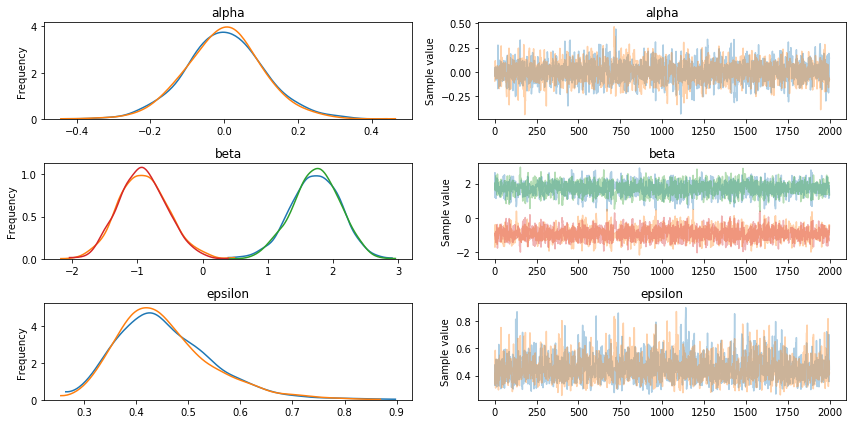

In [97]:
##2次の多項式モデル
with pm.Model() as model_p:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1, shape=x_1s.shape[0])  
    epsilon = pm.HalfCauchy('epsilon', 5)
    mu = alpha + pm.math.dot(beta, x_1s)
    y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y_1s)
    trace_p = pm.sample(2100, njobs=1)

chain_p = trace_p[100:]
pm.traceplot(chain_p);

pm.summary(chain_p)

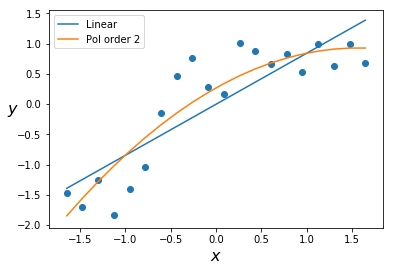

In [98]:
##元のデータに対してのモデリングを図示する
alpha_l_post = chain_l['alpha'].mean()
betas_l_post = chain_l['beta'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_l_post = alpha_l_post + betas_l_post * x_1s[0]

plt.plot(x_1s[0][idx], y_l_post[idx], label='Linear')

alpha_p_post = chain_p['alpha'].mean()
betas_p_post = chain_p['beta'].mean(axis=0)
y_p_post = alpha_p_post + np.dot(betas_p_post, x_1s)

plt.plot(x_1s[0][idx], y_p_post[idx], label='Pol order {}'.format(order))

plt.scatter(x_1s[0], y_1s)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0);
plt.legend()

In [100]:
##dicは消された模様
# dic_l = pm.dic(trace=trace_l, model=model_l)
# dic_p = pm.dic(trace=trace_p, model=model_p)
waic_l = pm.waic(trace=trace_l, model=model_l)
waic_p = pm.waic(trace=trace_p, model=model_p)
loo_l = pm.loo(trace=trace_l, model=model_l)
loo_p = pm.loo(trace=trace_p, model=model_p)

/anaconda3/lib/python3.6/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


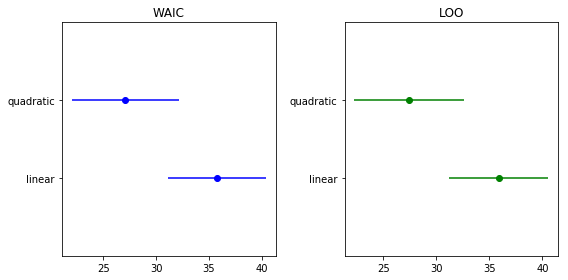

In [101]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
for idx, ic in enumerate((waic_l, waic_p)):
    plt.errorbar(ic[0], idx, xerr=ic[1], fmt='bo')
plt.title('WAIC')
plt.yticks([0, 1], ['linear', 'quadratic'])
plt.ylim(-1, 2)

plt.subplot(122)
for idx, ic in enumerate((loo_l, loo_p)):
    plt.errorbar(ic[0], idx, xerr=ic[1], fmt='go')
plt.title('LOO')
plt.yticks([0, 1], ['linear', 'quadratic'])
plt.ylim(-1, 2)
plt.tight_layout()

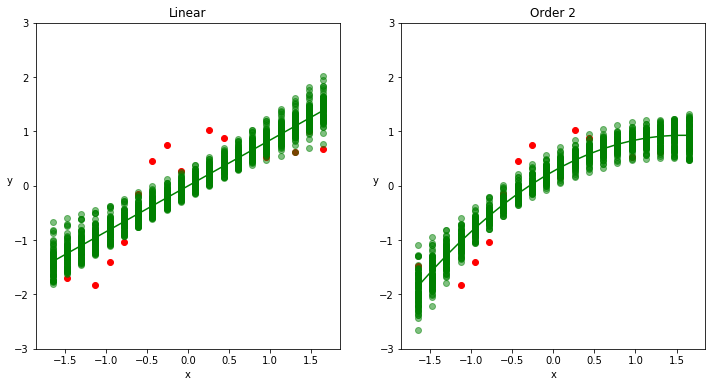

In [102]:
##事後予測チェック(モデル精度を測るものではなく、モデル改良のために使ったり、モデルの境界を把握したりするために使う)
##例えば、どこかの説明変数の値だけ予測がうまくできていないなどの判断ができる
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.scatter(x_1s[0], y_1s, c='r');
plt.ylim(-3, 3)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('Linear')

##モデルの各点の取りうる値の広さをプロット
for i in range(0, len(chain_l['alpha']), 50):
    plt.scatter(x_1s[0], chain_l['alpha'][i] + chain_l['beta'][i]*x_1s[0], c='g', edgecolors='g', alpha=0.5);

##モデルを描く    
plt.plot(x_1s[0], chain_l['alpha'].mean() + chain_l['beta'].mean()*x_1s[0], c='g', alpha=1)

plt.subplot(122)
plt.scatter(x_1s[0], y_1s, c='r');
plt.ylim(-3, 3)
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.title('Order {}'.format(order))
for i in range(0, len(chain_p['alpha']), 50):
    plt.scatter(x_1s[0], chain_p['alpha'][i] + np.dot(chain_p['beta'][i], x_1s), c='g', edgecolors='g', alpha=0.5)
idx = np.argsort(x_1)
plt.plot(x_1s[0][idx], alpha_p_post + np.dot(betas_p_post, x_1s)[idx], c='g', alpha=1);

# 第7章 混合モデル

データがある単一の分布から発生しているものではなく、分布の混合したものから発生すると仮定するモデルを混合モデルという

例えば、身長といっても、男性と女性のそれぞれの分布から成り立っていると考えるのは理にかなう。また、手書き数字のグループの記述をする際にも各数字ごとの分布を仮定して、モデリングすることは理にかなうはず。

たいていの奇妙な分布の説明は正規分布のいくつかの組み合わせ(ガウス混合モデル)で説明できる。

いくつかの分布を用意したのち、データをどの分布に当てはめるかの判断が必要。その際に、潜在変数という確率変数を用いて分布への割り当てが行われる

Text(0.5, 0, '$x$')

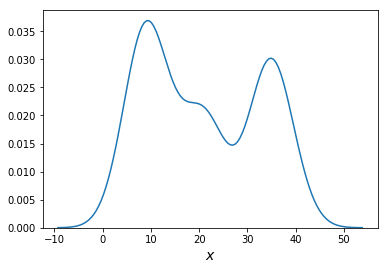

In [106]:
##擬似データの作成
np.set_printoptions(precision=2)

clusters = 3
n_cluster = [90, 50, 75]
n_total = sum(n_cluster)
means = [9, 21, 35]
std_devs = [2, 2, 2]

mix = np.random.normal(np.repeat(means, n_cluster), np.repeat(std_devs, n_cluster))
sns.kdeplot(np.array(mix))
plt.xlabel('$x$', fontsize=14)

コイン投げでは、尤度としてベルヌーイ分布を用いた。そして、表の出る確率変数として、ベータ分布を事前分布として用いた。<br>
ベルヌーイ分布をk個の結果へと一般化させたものがカテゴリカル分布で、ベータ分布が一般化されたものがディリクレ分布という。

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>NUTS: [p]
>CategoricalGibbsMetropolis: [category]
Sampling 3 chains: 100%|██████████| 31500/31500 [04:10<00:00, 125.73draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25b874e0>,
      dtype=object)

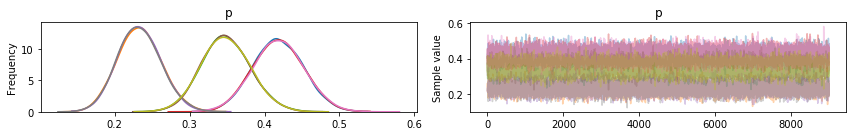

In [108]:
##正規混合分布モデル(平均と標準偏差が既知とした場合)
with pm.Model() as model_kg:
    p  =pm.Dirichlet('p' , a = np.ones(clusters))
    category = pm.Categorical('category' , p=p , shape = n_total)
    
    means = pm.math.constant([10 , 20 , 35])
    y = pm.Normal('y' , mu = means[category] , sd=2 , observed=mix)
    
    trace_kg = pm.sample(10000 , njobs =3)

chain_kg = trace_kg[1000 : ]
varnames  =['p']
pm.traceplot(chain_kg , varnames)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [sd, means, p]
>CategoricalGibbsMetropolis: [category]
100%|██████████| 10500/10500 [03:48<00:00, 45.91it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c26a60ba8>,
      dtype=object)

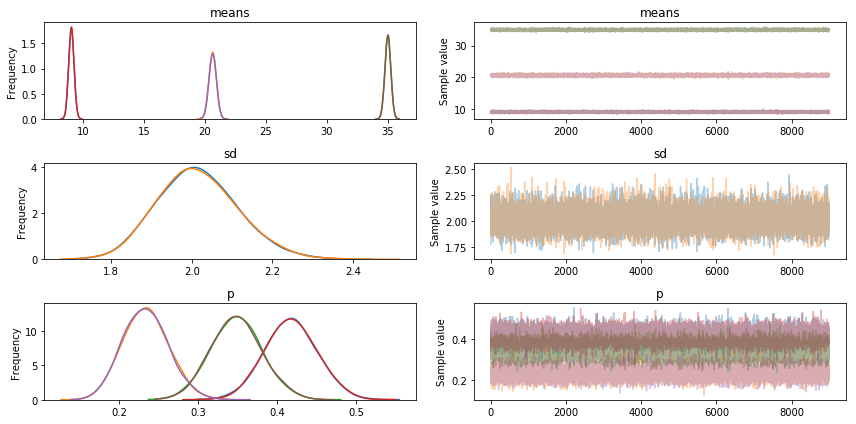

In [109]:
##正規混合分布モデル(平均と標準偏差も階層化したもの)
with pm.Model() as model_ug:
    p = pm.Dirichlet('p', a=np.ones(clusters))
    category = pm.Categorical('category', p=p, shape=n_total) 

    means = pm.Normal('means', mu=[10, 20, 35], sd=2, shape=clusters)
    sd = pm.HalfCauchy('sd', 5)
    y = pm.Normal('y', mu=means[category], sd=sd, observed=mix)

    trace_ug = pm.sample(10000, njobs=1)

chain_ug = trace_ug[1000:]
varnames_ug = ['means', 'sd', 'p']
pm.traceplot(chain_ug, varnames_ug)

In [110]:
##統計量の表示
pm.summary(chain_ug , varnames_ug)

mean        sd  mc_error    hpd_2.5   hpd_97.5         n_eff  \
means__0   9.040290  0.213765  0.001365   8.611388   9.443090  20883.597821   
means__1  20.631946  0.292999  0.001859  20.050904  21.193014  22118.067798   
means__2  35.003248  0.233567  0.001471  34.555451  35.473723  23578.106766   
sd         2.015401  0.099298  0.000741   1.825636   2.211124  17783.826296   
p__0       0.417799  0.033095  0.000218   0.354340   0.482984  21431.321834   
p__1       0.233579  0.028655  0.000199   0.177220   0.288644  18722.146612   
p__2       0.348621  0.032150  0.000218   0.285929   0.412458  21164.099158   

              Rhat  
means__0  0.999968  
means__1  0.999945  
means__2  0.999962  
sd        0.999951  
p__0      0.999983  
p__1      0.999990  
p__2      0.999945

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 50/50 [00:00<00:00, 574.63it/s]


Text(0.5, 0, '$x$')

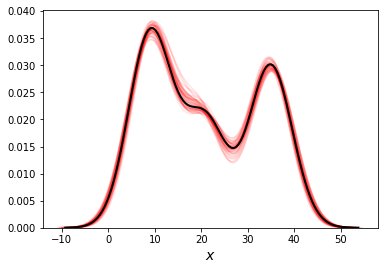

In [111]:
##混合モデルの出力
ppc = pm.sample_ppc(chain_ug , 50 , model_ug)
for i in ppc['y']:
    sns.kdeplot(i , alpha=0.1 , color = 'r')
sns.kdeplot(np.array(mix) , lw=2 , color='k')
plt.xlabel('$x$' ,fontsize=14)

今、潜在変数もモデルに含めて考えている(数式的に言うと、積分の式に含めている)が、含めると探索などにかかる時間も付加されて、計算時間が長くなる。<br>
そこで、潜在変数を周辺化(MCMCなどのサンプリング的な方法で行う)してしまうと良い。

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, means, p]
100%|██████████| 5500/5500 [00:08<00:00, 675.48it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c228907b8>,
      dtype=object)

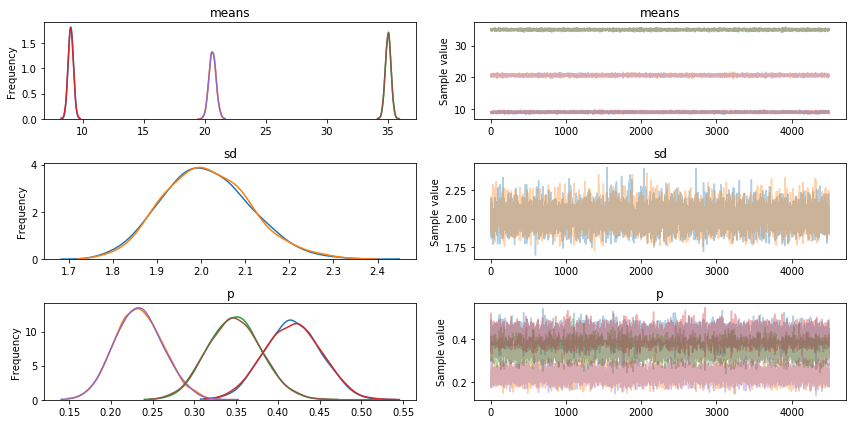

In [112]:
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))

    means = pm.Normal('means', mu=[10, 20, 35], sd=2, shape=clusters)
    sd = pm.HalfCauchy('sd', 5)
    ##さっきまでとの差はNomalMixtureを使って、wで周辺化するものを指定している
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=mix)

    trace_mg = pm.sample(5000, njobs=1)

chain_mg = trace_mg[500:]
varnames_mg = ['means', 'sd', 'p']
pm.traceplot(chain_mg, varnames_mg)

何かを数える時の分布としてポアソン分布が使える。二項分布はポアソン分布の特殊な場合を表す。しかし、何かを数える時には0が多く存在することがある。その場合は、データにうまくフィットしない場合がある。そんな時には0過剰ポアソン(ZIP分布)分布を用いる良い。

次にこのZIP分布を用いたモデリング例を行う。子供の人数とキャンピングカーでの来訪の有無の二つの説明変数に対して、釣れた魚の数をモデリングする。

In [113]:
fish_data = pd.read_csv('/Users/shintaro/Downloads/BAP/fish.csv')
fish_data.head()

nofish  livebait  camper  persons  child        xb        zg  count
0       1         0       0        1      0 -0.896315  3.050405      0
1       0         1       1        1      0 -0.558345  1.746149      0
2       0         1       0        1      0 -0.401731  0.279939      0
3       0         1       1        2      1 -0.956298 -0.601526      0
4       0         1       0        1      0  0.436891  0.527709      1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, psi]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:06<00:00, 826.92draws/s]
The acceptance probability does not match the target. It is 0.8804974250888599, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c28758da0>,
      dtype=object)

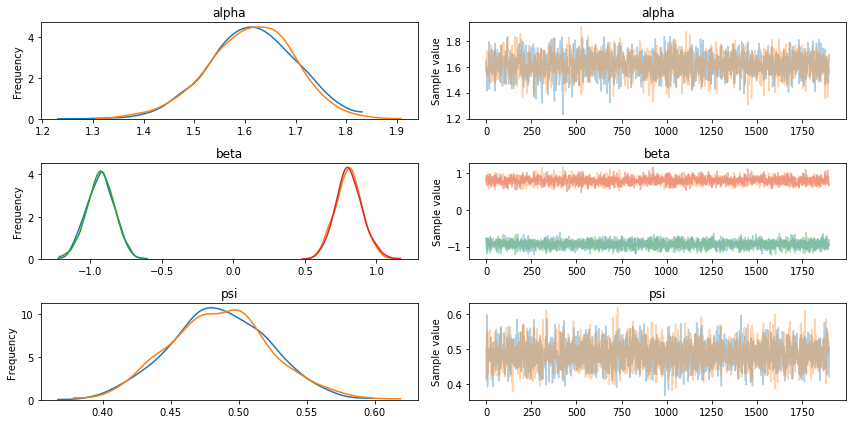

In [116]:
with pm.Model() as ZIP_reg:
    psi = pm.Beta('psi' , 1 , 1)
    
    alpha = pm.Normal('alpha'  ,0 , 10)
    beta = pm.Normal('beta' , 0 , 10  ,shape=2)
    ##線形回帰
    lam = pm.math.exp(alpha + beta[0] * fish_data['child'] + beta[1]*fish_data['camper'] )
    y = pm.ZeroInflatedPoisson('y' , psi , lam , observed=fish_data['count'])
    trace_ZIP_reg = pm.sample(2000 , njobs=2)
    
chain_ZIP_reg  =trace_ZIP_reg[100:]
pm.traceplot(chain_ZIP_reg)

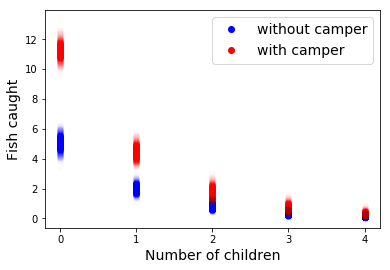

In [118]:
##事後結果の可視化
children =  [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []
thin = 5
for n in children:
    without_camper = chain_ZIP_reg['alpha'][::thin] + chain_ZIP_reg['beta'][:,0][::thin] * n
    with_camper = without_camper + chain_ZIP_reg['beta'][:,1][::thin]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))

plt.plot(children, fish_count_pred_0, 'bo', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'ro', alpha=0.01)

plt.xticks(children);
plt.xlabel('Number of children', fontsize=14)
plt.ylabel('Fish caught', fontsize=14)
plt.plot([], 'bo', label='without camper')
plt.plot([], 'ro', label='with camper')
plt.legend(fontsize=14)

ここまでは、0を過剰に生成する要因を直接モデル化せずに、過剰な0に対処する方法を学んだ。<br>
他の方法としては、異常な値をロジスティック回帰を応用することでも対処できる。いわゆる頑健ロジスティック回帰

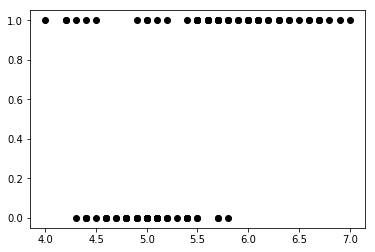

In [119]:
##irisに異常なデータを加えたもの
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values
y_0 = np.concatenate((y_0, np.ones(6)))
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4]))
x_0_m = x_0 - x_0.mean()
plt.plot(x_0, y_0, 'o', color='k')

次にやろうとすることは以下のロジスティック回帰<br>
p = π0.5 + (1-π) logistic(α+βX)<br>
ランダム性を加えることで頑健なものになっている

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [pi, beta, alpha_tmp]
100%|██████████| 2500/2500 [00:02<00:00, 1074.24it/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c30953588>,
      dtype=object)

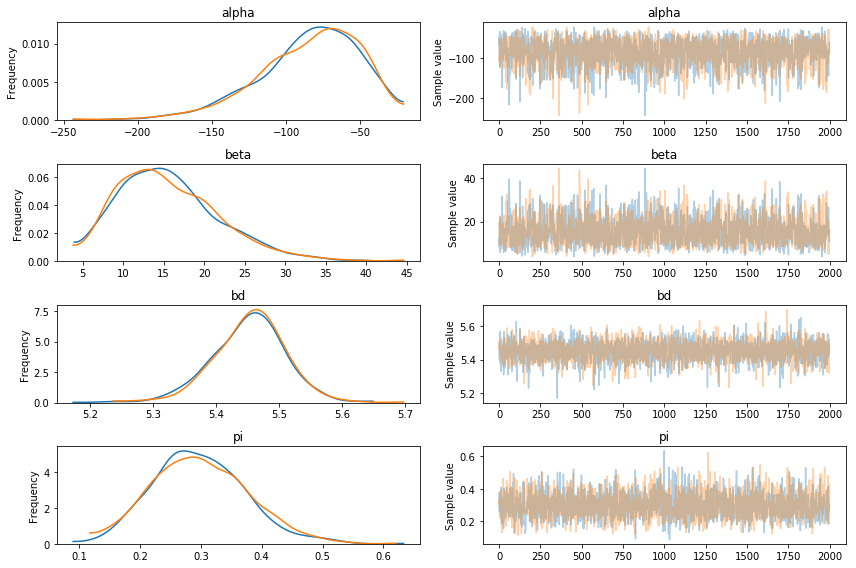

In [121]:
with pm.Model() as model_rlg:
    alpha_tmp = pm.Normal('alpha_tmp' , mu=0 ,sd=100)
    beta = pm.Normal('beta' , mu=0  ,sd=10)
    mu=alpha_tmp + beta * x_0_m
    theta = pm.Deterministic('theta' , 1/(1+pm.math.exp(-mu)))
    
    ##ランダムな確率の設定
    pi = pm.Beta('pi' , 1,1)
    ##結果変数がランダムな推測πから生起orロジスティック回帰から確率1-πで生起すると仮定する 
    p = pi*0.5 +(1-pi)*theta
    
    alpha  =pm.Deterministic('alpha' , alpha_tmp - beta*x_0.mean() )
    bd = pm.Deterministic('bd' , -alpha/beta)
    
    yl = pm.Bernoulli('yl', p=p, observed=y_0)
    trace_rlg = pm.sample(2000, njobs=1)
varnames = ['alpha', 'beta', 'bd', 'pi']
pm.traceplot(trace_rlg, varnames)

Text(0, 0.5, '$\\theta$')

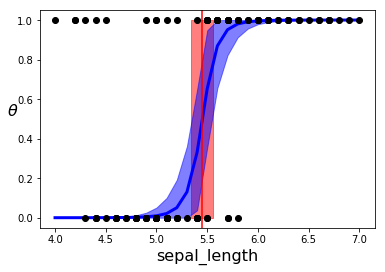

In [122]:
##確認として、データセットに対してのHPDを図示して確認
##異常データに対してもうまくフィッティングできている
theta = trace_rlg['theta'].mean(axis=0)
idx = np.argsort(x_0)
plt.plot(x_0[idx], theta[idx], color='b', lw=3);
plt.axvline(trace_rlg['bd'].mean(), ymax=1, color='r')
bd_hpd = pm.hpd(trace_rlg['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='r', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')
theta_hpd = pm.hpd(trace_rlg['theta'])[idx]
plt.fill_between(x_0[idx], theta_hpd[:,0], theta_hpd[:,1], color='b', alpha=0.5)

plt.xlabel(x_n, fontsize=16)
plt.ylabel('$\\theta$', rotation=0, fontsize=16)

この章で見てきたようなポアソン分布は離散型のモデルということに注意。頑健ロジスティックは連続型モデルでも用いることは可能。<br>
負の二項分布がある。これは、ガンマ-ポアソン混合モデルとして理解できる。これはよくカウントデータにある過剰分散(データの分散がモデルの分散よりも大きくなる現象)を回避するために使われる。

# 第8章 ガウス過程(GP)

ここからはノンパラメトリックモデルを扱う。ノンパラメトリックモデルは、パラメータの数がデータの増加と共に増加するモデル。
そのため、データを記述するのに必要な有限個までのパラメータに減らそうとする。

ノンパラメトリック統計学→パラメータを減らすために効果的にデータを使用すること

**ガウス過程**<br>
データに対する尤度の関数として、良いものがわからない時、事前分布を設定した。この事前分布は多変量正規分布で議論できる。<br>
全てのサイズnのベクトルxが未知の平均と分散からなる正規分布に従うyと対応する場合は、n個の多変量正規分布があることになる。<br>
入力xと出力yの組みは無限にある。原理的には、無限の多変量正規分布が必要なのだが、その数学的な過程はガウス過程と呼ばれる。<br>
ガウス過程は平均関数と共分散関数で定義される。また、連続空間における全ての点は正規分布に従う変数と関連しており、GPは無限に多い確率変数の同時分布である。

実用上では、平均関数はにセットされるので、共分散関数によって制御される。<br>

### GPからのサンプリング

無限のGPを有限の多変量正規分布へ縮小させる<br>
これはモデルの外にある無限の次元に渡って、周辺化することで行われる。<br>
→実際のところ、データ点でGPを評価すれば良い。つまり、データ点と同じ次元の多変量正規分布が使えるようにする。

共分散関数はxが変化する時にyがどう変化するかを記述する関数

Text(0, 0.5, '$f(x)$')

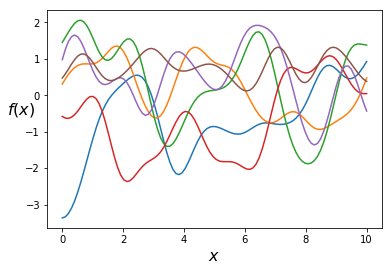

In [124]:
##GP事前分布のイメージ
##0の周りに中心かされていることがわかる
np.random.seed(1)
x = np.random.uniform(0, 10, size=20)
y = np.random.normal(np.sin(x), 0.2)

squared_distance = lambda x, y: np.array([[(x[i] - y[j])**2 for i in range(len(x))] for j in range(len(y))])
np.random.seed(1)
test_points = np.linspace(0, 10, 100)
cov = np.exp(-squared_distance(test_points, test_points))
plt.plot(test_points, stats.multivariate_normal.rvs(cov=cov, size=6).T)
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$f(x)$', fontsize=16, rotation=0)

この後は理論の話が続くが、結局、GPの事後分布を得るための数学的な必要な数式の説明をしているだけ。使うことを考えるなら、p262の上の設定を確認すればおけ。

In [138]:
from PIL import Image

#画像の読み込み
im = Image.open("/Users/shintaro/Downloads/BAP/GP.png")

#表示
im.show()

# Pythonで体験するベイズ推論からの補足内容

•例えば、ベイズABテストでは、pymc3において推定したい確率をサンプリングする考えなら(事後分布では考えないなら)例えば両方の購入確率をp_a、p_bとする。そして、その事後分布を見る。また、その差の確率はtrace = pm.sampleとして、(trace［'変数名1'］ - trace［'変数名2'］< 0 or > 0 ).mean でわかる。

•ある現象のそれぞれの単体の出来事の何かの確率を考える時、それぞれの単体でのサンプル数が違うにも関わらず、それらの順位をつけたい時は、求めた事後分布の95%信頼区間の下限値でソートすると良い。(保守的な評価ができる)

### ベイズにおける損失関数

モデリングの目的に沿って、損失関数を定義することでモデリングからの期待損失(想定されうる被害などのマイナス面の予想)がわかる

**ベイズの誤差において知られていること**<br>
①二乗誤差を用いた場合は、ベイズ行動は事後分布の平均になる。つまり、誤差関数を二乗誤差の元で考えるとき、損失の事後分布を決定変数として事後分布を求めて、その分布の平均を期待誤差として定義できる。<br>
②期待絶対損失において、事後分布の中央値は期待絶対損失を最小化させる<br>
③MAP推定値は0-1損失を使った場合の解になる

**注意**<br>
ここで注意なのは、上のように典型的に知られていること以外の損失を考える時は、モデリングを行なった後に、与えられるデータ幅において発生させたデータの損失を計算する必要があること。<br>
期待損失は事後分布のサンプリングから求まる訳ではない。というのも、ベイズのモデリングは、分布のパラメータの推定であり、損失を計算するものではないから。<br>
つまり、ベイズ的に期待損失を考える時は、①モデリングでパラメータの推定 ②損失関数を定義して、期待損失の最小化or最大化を求める。その際、高次元関数の損失関数を考える時には、パッケージとしてscipyのfminを使うとやりやすい。

**<ベイズにおける損失関数のイメージ>**<br>
ベイズの観点でいうと損失関数はモデル評価なイメージに近い。事前分布に関する設定など色々変えて、設定した期待損失を見比べて、一番良さげな事前分布やハイパーパラメータの設定を探すといった具合。注意なのは、ベイズに損失関数の概念を持ち込む時には、分析目的に即して決められた損失関数が設定されるが、それは分析者で勝手に途中で変更が可能になってしまう。なので、分析前に入念に損失関数の定義については決めなければならない。

**知っておくべき事前分布**<br>
ガンマ分布→指数分布の一般形<br>
ウィシャート分布→共分散行列の事前分布に適している<br>
ベータ分布→一様分布の一般形。尤度関数とし事前分布を選び、そのp値の事前分布をベータ分布で定めると、事後分布はベータ分布になる<br>


### ベイズ多腕バンディット

ここから考えるのは、最良の選択はどれかという観点でのモデリングを考える。確率的にどれが良いかというよりは、シミュレーション的にどれがもっとも戦略として優れているかのモデリング(どのパターンがもっとも多いor少ない頻度になるのかの判断)を行なっている。

適用事例としては、<br>
ネット広告: 広告出稿パターンをいくつか持っているが、どの広告戦略を最大化し、逆にどれを最小化するのかなどの戦略選択に用いることができる。<br>
金融: リターンが時間的に変化するストックオプションでどのストックオプションがリターンを最大化するのかの選択

今回は、スロットマシンのシミュレーションで、試行回数によってどのマシンが選ばれやすいのかということのシミュレーションを行うに等しい。(テキストに書いてある想定は少しおかしい？)<br>
**多腕バンディット的にやると、偶然当たる確率、偶然当たらない確率というものを考慮している。今回、ベイズ多腕バンディットの「ベイズ」は各スロットマシンの選ばれる分布をシミュレーション的に得られるデータを用いて、分布を更新することに値する。<br>
つまり、今回をネット広告出稿に置き換えると、各広告出稿パターンのCV率などがわかっていて(これはあらかじめ推定しておく必要がある)、各広告出稿パターンをベータ分布から発生させるものとして、各広告パターンから選ばれた分布ランダムな値の大きさでどの広告出稿パターンを選ぶか決定し(分布の幅が狭いほど選ばれやすくなる(大きな値が出やすいから))、そのCV確率で本当にCVorCVされないかを決定。これによって、全採択回数とそれに対するCV率がわかって、分布の凹凸が決定されていく。**<br>

↓<br>
**つまり、想定利用シーンとしては、広告を見たユーザーの回数によって、各広告のCV確率のシミュレーションができ、相対的にどの広告出稿パターンが良いのかを検討できる。例えば、あるユーザーがあるサイトの広告を1万回見ていて、広告出稿パターンがABCとあり、見た回数によって、それぞれの確率密度が、どれくらいかつ、どれくらいの分布の幅を持っているのかの判断ができる。そこで、あるユーザーには、この段階では、広告Cは確率密度が小さいから、広告Cは出さないようにしようなどの意思決定ができる。**

In [37]:
from pymc import rbeta

class Bandits(object):
    
    '''
    N個のバンディット(今回の例で言うと、スロットマシン)を表すクラス
    p_array : 0~1の各スロットマシンの当たり確率
    メソッド : pull(i) : アームを引いた結果、当たるかどうか
    '''
    
    def __init__(self , p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)
        
    def pull(self , i):
        #指定indexのマシンのアームを引く。ランダム性を持たせるために、ランダム確率よりも大きいかで当たりorハズレの判定
        return np.random.rand() < self.p[i]
    
    def __len__(self):
        return len(self.p)
    
class BeysianStrategy(object):
    '''
    多腕バンディットのオンライン学習の実装
    bandits : バンディットの数
    メソッド: sample_bandits : n回引いて学習
    属性:
        N : サンプルの累計回数
        choices : N回のマシンの選択履歴
        bb_score : N回の勝ち負け履歴
    '''
    
    def __init__(self, bandits):
        self.bandits = bandits
        n_bandits = len(self.bandits)
        ##初期設定
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []
        
    def sample_bandits(self , n):
        bb_score = np.zeros(n)
        choices = np.zeros(n)
        
        for i in range(n):
            '''
            バンディットの事前分布からサンプリングしてもっとも大きな値のバンディットを選択する
            '''
            ##これはベータ分布を事前分布として、尤度関数を二項分布としている時に事後分布がベータ分布になる性質を書いている
            choice = np.argmax(rbeta(1+self.wins , 1+self.trials - self.wins))
            ##選択したバンディット(マシン)からサンプリングして、それが当たりorハズレを引く
            result = self.bandits.pull(choice)
            
            ##事前分布と勝ち負け履歴を更新
            self.wins[choice] += result
            self.trials[choice] +=1
            bb_score[i] = result
            self.N +=1
            choices[i] = choice
            
        ##試行が終わるたびにデータに保存
        self.bb_score = np.r_[self.bb_score , bb_score]
        self.choices = np.r_[self.choices , choices]
    
        

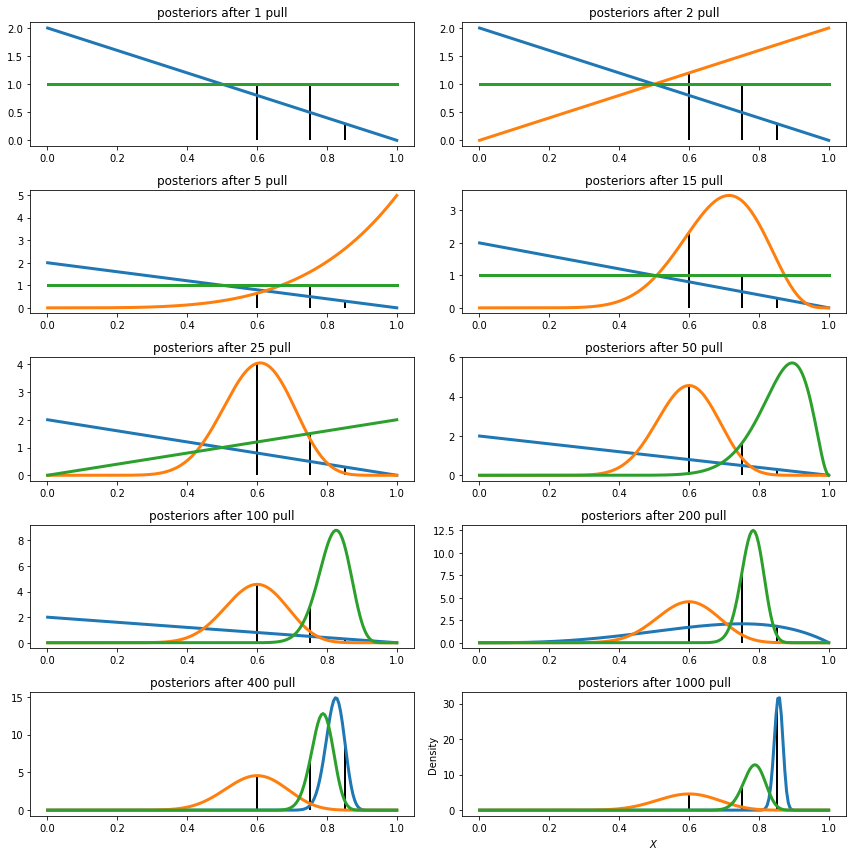

In [38]:
##データ幅(確率の幅)を定義
plt.figure(figsize=(12,12))
x = np.linspace(0.001 , 0.999 , 200)
from scipy.stats import beta

def plot_priors(baysian_strategy , prob , lw=3 , alpha=0.2 , plt_vlines=True):
    ##プロット関数
    wins = baysian_strategy.wins
    trials = baysian_strategy.trials
    
    ##各マシンごとのプロット
    for i in range(prob.shape[0]):
        y = beta(1 + wins[i] , 1+trials[i] - wins[i])
        p = plt.plot(x , y.pdf(x) , lw=lw)
        
        if plt_vlines:
            plt.vlines(prob[i] , 0 , y.pdf(prob[i]) , lw=2)
        
        plt.title('posteriors after %d pull' % baysian_strategy.N)

    return

##各バンディットの当たり確率
hidden_prob = np.array([0.85 , 0.60 , 0.75])
bandits = Bandits(hidden_prob)
baysian_strat = BeysianStrategy(bandits)

##試行回数の設定
draw_samples = [1,1,3,10,10,25,50,100,200,600]

for i , j in enumerate(draw_samples):
    plt.subplot(5 , 2 , i+1)
    ##試行回数の引数を与えて分布をプロット
    baysian_strat.sample_bandits(j)
    plot_priors(baysian_strat , hidden_prob)

plt.xlabel('$X$')
plt.ylabel('Density')
plt.tight_layout()

        
        

これを見て、分かるように試行回数が多いなら、0.85のバンディットが選ばれやすいと言うことが分かる(今回はスロットマシンという想定が少しおかしい笑)

次にバンディットの戦略の良さを計算する<br>
リグレットといって、最初から最良の選択をし続けた場合との比較で小さい値ほど精度は良いとされる。

次のプロットは以下のリグレットである。<br>
①ランダム　: ランダムに選択したバンディットのアームを引く(これに精度が劣るならモデルを考え直した方が良い)<br>
②最大ベイズ信用区間上限 : 推定された確率の95%信用区間の上限がもっとも大きなバンディットを引く<br>
③ベイズUCB : UCBスコア(強化学習でよく用いられるスコア計算の値)が高いもののバンディットを引く<br>
④事後分布平均 : 事後分布平均が最も大きなバンディットを引く。<br>
⑤最大観測割合 : 現在までに観測された、当たりの最も多いバンディットを引く


In [41]:
#other strats.
# TODO: UBC strat, epsilon-greedy

import scipy.stats as stats

rand = np.random.rand()
beta = stats.beta


class GeneralBanditStrat(object):

    """
    Implements a online, learning strategy to solve
    the Multi-Armed Bandit problem.
    
    parameters:
        bandits: a Bandit class with .pull method
            choice_function: accepts a self argument (which gives access to all the variables), and 
                returns and int between 0 and n-1
    methods:
        sample_bandits(n): sample and train on n pulls.

    attributes:
        N: the cumulative number of samples
        choices: the historical choices as a (N,) array
        bb_score: the historical score as a (N,) array

    """
    
    def __init__(self, bandits, choice_function):
        
        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.score = []
        self.choice_function = choice_function

    def sample_bandits(self, n):
        
        score = np.zeros(n)
        choices = np.zeros(n)
        
        for k in range(n):
            #sample from the bandits's priors, and select the largest sample
            choice = self.choice_function(self)
            
            #sample the chosen bandit
            result = self.bandits.pull(choice)
            
            #update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            score[k] = result 
            self.N += 1
            choices[k] = choice
            
        self.score = np.r_[self.score, score]
        self.choices = np.r_[self.choices, choices]
        return 
        

def bayesian_bandit_choice(self):
    return np.argmax(np.random.beta(1 + self.wins, 1 + self.trials - self.wins))
    
def max_mean(self):
    """pick the bandit with the current best observed proportion of winning """
    return np.argmax(self.wins / (self.trials +1))

def lower_credible_choice( self ):
    """pick the bandit with the best LOWER BOUND. See chapter 5"""
    def lb(a,b):
        return a/(a+b) - 1.65*np.sqrt((a*b)/( (a+b)**2*(a+b+1)))
    a = self.wins + 1
    b = self.trials - self.wins + 1
    return np.argmax(lb(a,b))
    
def upper_credible_choice(self):
    """pick the bandit with the best LOWER BOUND. See chapter 5"""
    def lb(a,b):
        return a/(a+b) + 1.65*np.sqrt((a*b)/((a+b)**2*(a+b+1)))
    a = self.wins + 1
    b = self.trials - self.wins + 1
    return np.argmax(lb(a,b))
    
def random_choice(self):
    return np.random.randint(0, len(self.wins))
    
    
def ucb_bayes(self):
    C = 0
    n = 10000
    alpha =1 - 1./((self.N+1))
    return np.argmax(beta.ppf(alpha,1 + self.wins, 1 + self.trials - self.wins))



class Bandits(object):
    """
    This class represents N bandits machines.

    parameters:
        p_array: a (n,) Numpy array of probabilities >0, <1.

    methods:
        pull( i ): return the results, 0 or 1, of pulling 
                   the ith bandit.
    """
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)
        
    def pull(self, i):
        #i is which arm to pull
        return np.random.rand() < self.p[i]
    
    def __len__(self):
        return len(self.p)

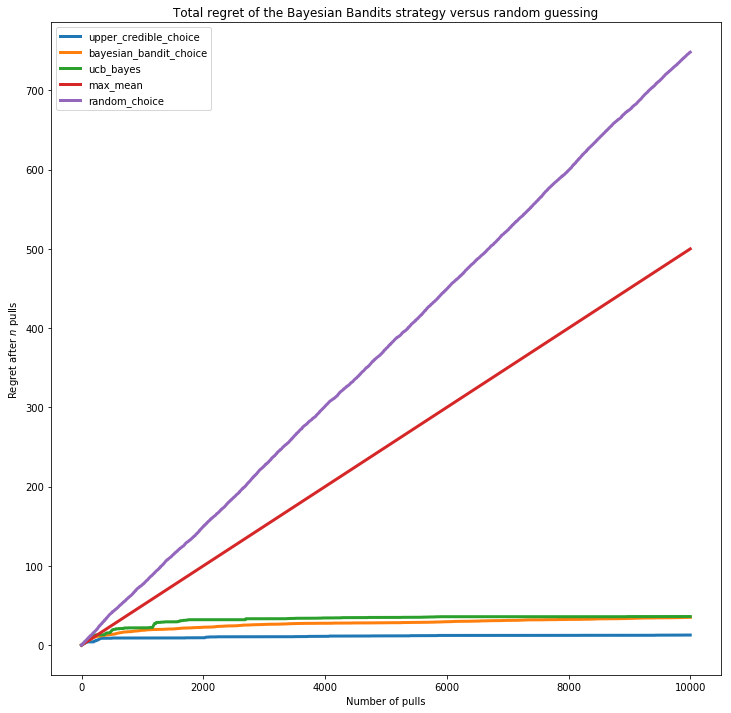

In [42]:
plt.figure(figsize=(12,12))
##各マシンの当たり確率の設定
hidden_prob = np.array([0.15, 0.2, 0.1, 0.05]) 
bandits = Bandits(hidden_prob)

def regret(probabilities, choices):
    w_opt = probabilities.max()
    return (w_opt - probabilities[choices.astype(int)]).cumsum()

##評価方法の関数を呼び出すための設定
strategies= [upper_credible_choice,
             bayesian_bandit_choice,
             ucb_bayes,
             max_mean,
             random_choice]
##各バンディットとその評価法をセットにしたものを作成
algos = []
for strat in strategies:
    algos.append(GeneralBanditStrat(bandits, strat))

##作成したバンディットと評価法のサンプリングから得られた各値を取得
for strat in algos: 
    strat.sample_bandits(10000)

##それぞれの評価法のリグレットを計算
for i,strat in enumerate(algos):
    _regret = regret(hidden_prob, strat.choices) 
    plt.plot(_regret, label=strategies[i].__name__, lw = 3)

plt.title("Total regret of the Bayesian Bandits strategy "
          "versus random guessing")
plt.xlabel("Number of pulls")
plt.ylabel("Regret after $n$ pulls")
plt.legend(loc="upper left");

↑これは、リグレットがベイズ的な方法によるものが低い、つまり、良い結果であると言える。ただし、これは、一回のシミュレーションなので、このシミュレーションを200回行なって得られる期待リグレットを考えてみる。ここでは、ランダムなものと当たり割合が高いものは明らかに精度が低いので、省いて評価する。

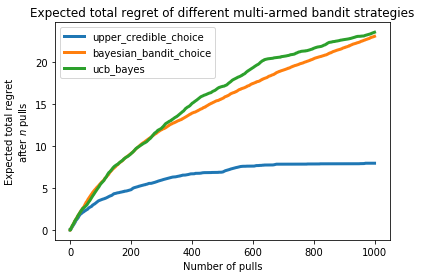

In [58]:
trials  =10
##1回のシミュレーションが1000回試行で、評価が3パターン
expected_total_regret = np.zeros((1000 , 3))

for i_strat , strat in enumerate(strategies[:-2]):
    for i in range(trials):
        general_strat = GeneralBanditStrat(bandits , strat)
        general_strat.sample_bandits(1000)
        _regret = regret(hidden_prob ,general_strat.choices )
        expected_total_regret[: ,i_strat] += _regret
    ##各々の評価法の全シミュレーションが終わったらプロット
    plt.plot(expected_total_regret[: , i_strat] / trials , lw=3 , label=strat.__name__)
    
plt.title("Expected total regret of "
          "different multi-armed bandit strategies") 
plt.xlabel("Number of pulls")
plt.ylabel("Expected total regret\n"
           "after $n$ pulls")
plt.legend(loc="upper left");

### 共役事前分布を用いると嬉しいことは、事後分布がわかるためにMCMCの探索を行わなくて良いこと。コーディングはめんどくさいが、解析にかかる時間は少なくなる。

ただし、共役事前分布は主観的な事前分布として使用できる時かつ、主観的な事前分布と共役事前分布が一致する時に限った方が良さそう。<br>
共役事前分布が存在するのは一般に単純で、1次元の問題に限られる。つまり、様々な現実問題に適用させる時には裏で様々な事象が関連してくるので、現実問題に適用させる時には注意。ぶっちゃけ、PC性能が今は高いから、演算処理能力が高いなら、共役事前分布を使っていたとしても、サンプリングしてしまっても良いかも。

さっきのベイズ多腕バンディットでのコーディングは事後分布がわかっていたので、ベタ書きで事後分布を表現できた。もし、事後分布がわからないなら、MCMCを行なって、推定するのをコーディングに含めなければならない。

### ベイズA/Bテスト

ベイズ版のt検定がある。BESTモデルと言われる。t分布を尤度として、そのハイパーパラメータのμ、σ、ν(分布にどれくらい外れ値を含むかのパラメータ)に事前分布を設定する。<br>
μは正規分布、σは一様分布とする。どちらもデータの標準偏差の1000倍を取るような幅の広い設定にする。(実質的に無情報事前分布となる。A/Bテストであるから、主観的な考えを事前分布から排除するという意味では有効)<br>
これをA/Bのそれぞれで設定する。νはそれぞれの平均に一致しないように?λをシフトさせた値にする。

In [16]:
##擬似データの発生
N  = 250
mu_a , std_a = 30 ,4
mu_b , std_b = 26 ,7

##ユーザーのページ滞在時間
stay_a = np.random.normal(mu_a , std_a , size=N)
stay_b = np.random.normal(mu_b , std_b , size=N)

/anaconda3/lib/python3.6/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -1,577.4, ||grad|| = 0.14056: 100%|██████████| 34/34 [00:00<00:00, 2046.71it/s]        
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [nu, std_B, std_A, mu_B, mu_A]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:03<00:00, 866.81draws/s] 


mean         sd  mc_error    hpd_2.5    hpd_97.5        n_eff  \
mu_A   30.270431   0.248902  0.005308  29.744955   30.747950  1983.784283   
mu_B   25.582839   0.458245  0.011727  24.666407   26.473864  1733.866623   
std_A   3.794830   0.177453  0.003969   3.464669    4.134048  2242.136682   
std_B   7.085686   0.338616  0.006587   6.415896    7.700472  2834.000677   
nu     66.403043  35.525363  0.795445  16.240624  137.780647  1923.815098   

           Rhat  
mu_A   1.000812  
mu_B   0.999477  
std_A  1.001620  
std_B  0.999525  
nu     0.999771

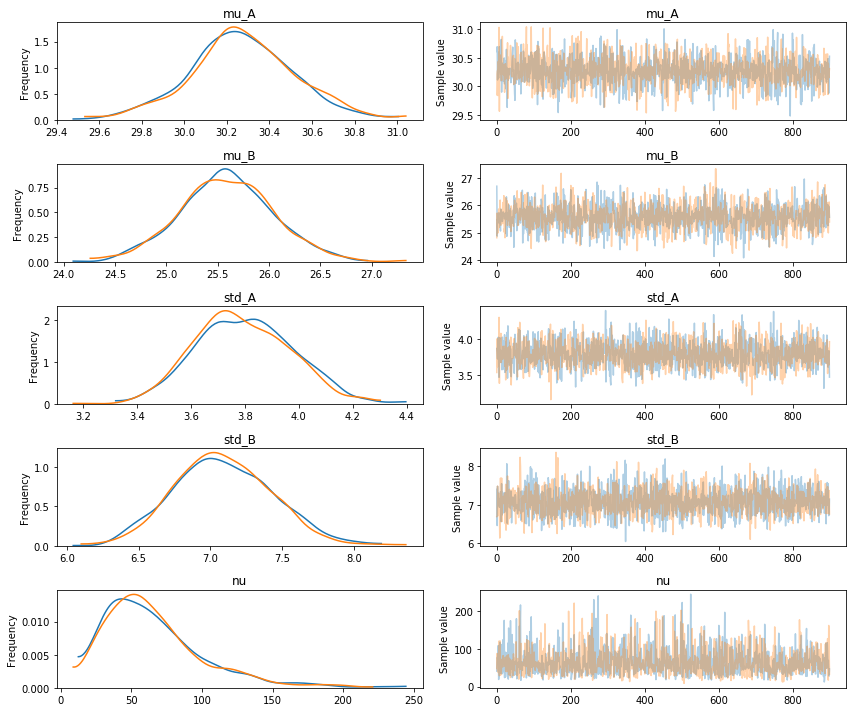

In [17]:
##モデル作成
import pymc3 as pm

##事前分布のパラメータの設定
pooled_mean = np.r_[stay_a , stay_b].mean()
pooled_std = np.r_[stay_a , stay_a].std()


with pm.Model() as t_test:
    ##事前分布の設定
    mu_A = pm.Normal('mu_A' , mu=pooled_mean , sd=pooled_std*1000)
    mu_B = pm.Normal('mu_B' , mu=pooled_mean , sd=pooled_std*1000)
    std_A = pm.Uniform('std_A' , pooled_std/1000 , pooled_std*1000)
    std_B = pm.Uniform('std_B' , pooled_std/1000 , pooled_std*1000)
    nu = pm.Exponential('nu' , 1.0/29)
    
    ##尤度の設定
    y_A = pm.StudentT('y_A' , mu=mu_A , sd=std_A , nu=nu , observed = stay_a )
    y_B = pm.StudentT('y_B' , mu=mu_B , sd=std_B  , nu=nu, observed = stay_b )
    
    ##推論設定
    start = pm.find_MAP()
    trace = pm.sample(1000 , start =start , njobs=2 )
    
chain = trace[100:]
pm.traceplot(chain)
pm.summary(chain)

この結果から、Aのサイトの方が滞在時間が長く、またその揺れ幅も小さい。つまり、サイト的にはAが優れていると言える。

例えば、同様な手法でCV率を事後分布から知りたい時には、これも事後分布を求めるしかない。間違っても、それぞれのCV率の事後分布の平均の値を使って、計算使用してはだめ。これをやるとだめなのは、各事後分布の持つ不確実さを無くしているから。

Text(0, 0.5, 'Density')

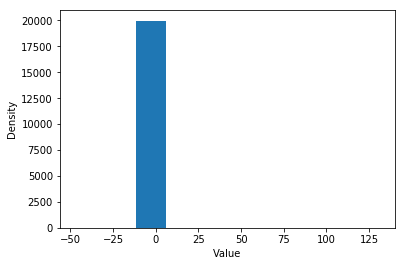

In [41]:
##例えば先のモデリングがCVの事後分布を得るものだったとして、CV率の向上を見る例。

from scipy.stats import t
import matplotlib.pyplot as plt
def relative_increase(a,b):
    return (a-b)/b


samples=20000
t_A = t(df = chain['nu'].mean() , loc=chain['mu_A'].mean() , scale=chain['std_A'].mean())
t_B = t(df = chain['nu'].mean() , loc=chain['mu_B'].mean() , scale=chain['std_B'].mean())

t_A_sample = t_A.rvs(size=samples)
t_B_sample = t_B.rvs(size=samples)

relative = relative_increase(t_A_sample , t_B_sample)

plt.hist(relative)
plt.xlabel('Value')
plt.ylabel('Density')

In [42]:
##リフト値の向上の確率
print((relative > 0.2).mean())
print((relative > 0.5).mean())

0.47905
0.23775


### ベイズでも点推定(一つの値を問われる時)が必要な時<br>

事後分布に偏りがない時は、平均値や中央値を返すのはあり。しかし、偏りがある場合は適していない。<br>
方法としては50%以下のパーセンタイル点を返すこと。これは過小評価して、見積もることに同値である。慎重な推定になる。また、より多くのデータを手にして、正確な事後分布が得られるようになると、分布の幅が狭くなり、どのパーセンタイルを選んでもほぼ同値になる。そうすることで、50%以下のパーセンタイルを選んでも、その値の信用度は慎重かつ増す。